# Identifiation system basing on behavioral biometrics: typing errors

## Configuration
### Load dependencies

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import Normalizer
import tensorflow_decision_forests as tfdf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.metrics import AUC
from sklearn.metrics import auc, roc_curve, confusion_matrix
from scipy.optimize import brentq
from scipy.interpolate import interp1d

from create_model import NUMBER_OF_FEATURES, N_GRAM_SIZE, create_dataset
from cv import calculate_metrics
from decorators import log_info
from draw_results import calculate_far_frr_eer, draw_system_t_roc_curve, plot_cmc, draw_system_roc_curve, \
    draw_classes_roc_curve, plot_confusion_metrics
# draw_system_t_roc_curve, draw_system_roc_curve
from logger import logger
from sklearn.metrics import roc_curve

In [35]:
"""
def run_cv_tf(model, X, y, X_valid, y_valid, n_splits=5, name='',
           plot_path='results_identification/', title = None, is_multiclass=True):

    kf = KFold(n_splits=n_splits)
    results = []
    # Initialization
    for train_index, test_index in kf.split(X):
        # Create train and test datasets using the indices from KFold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logger.info(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1000)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)
        X_valid, no_use_x, y_valid, no_use_y = train_test_split(X_valid, y_valid)
        model.fit(train_dataset)
        model.compile(metrics=[AUC()])
        predictions = model.predict(X_valid, verbose=2)
        predictions = np.hstack((1 - predictions, predictions))

        
        cm = confusion_matrix(y_valid, np.argmax(predictions, axis=1))
        print(cm)
        y_score = predictions[:, 1]
        # Compute ROC curve metrics
        far, tpr, _ = roc_curve(y_valid, y_score)
        frr = 1 - tpr

        # Find the point where FAR is closest to FRR
        eer_index = np.nanargmin(np.absolute(far - frr))
        eer = (far[eer_index] + frr[eer_index]) / 2
                

        fig = plt.figure(figsize=(15, 5))
        plt.title(f'{title}')
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.plot(far, tpr, color='steelblue', linewidth=2)
        ax1.plot(far[eer_index], tpr[eer_index], 'ro', label=f'EER: {eer:.2f}')
        ax1.set_title('ROC Curve')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend()
        
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.plot(frr, far, color='green', linewidth=2)
        ax2.plot(frr[eer_index], far[eer_index], 'ro', label=f'EER: {eer:.2f}')
        ax2.set_title('T-ROC Curve')
        ax2.set_xlabel('FRR (False Rejection Rate)')
        ax2.set_ylabel('FAR (False Acceptance Rate)')
        ax3 = fig.add_subplot(1, 3, 3)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Other user', 'User'], yticklabels=['Other user', 'User'], ax=ax3)
        ax3.set_title('Confusion Matrix')
        ax3.set_xlabel('Predicted')
        ax3.set_ylabel('Actual')

        
        plt.tight_layout()
        if plot_path:
            plt.savefig(f'{plot_path}')
        plt.show()
        
        # far, frr, eer, threshold = calculate_far_frr_eer(y_valid, predictions)
        # if user_name is None:
        #         user_name = 'User'
        # plot_confusion_metrics(y_valid, predictions, ['No user', user_name])
        # far, frr, eer, threshold = calculate_far_frr_eer(y_valid, predictions)
        # 
        # draw_system_roc_curve(far, frr, eer, plot_title="Receiver operating characteristic", file_path=f'{plot_path}/{name}_{NUMBER_OF_FEATURES}_{N_GRAM_SIZE}_far_frr.png')
        # draw_system_t_roc_curve(far, frr, eer, plot_title="T-Receiver operating characteristic",
        #                         file_path=f'{plot_path}/{name}_{NUMBER_OF_FEATURES}_{N_GRAM_SIZE}_t_roc.png')

    return pd.DataFrame(results)
    """""


In [47]:
def run_cv_tf(model, X, y, X_valid, y_valid, n_splits=5, name='',
           plot_path='results_identification/', title = None, is_multiclass=True):

    kf = KFold(n_splits=n_splits)
    results = []
    # Initialization
    all_far = []
    all_frr = []
    all_tpr = []
    all_eer = []
    cumulative_cm = np.zeros((2, 2)) 
    for train_index, test_index in kf.split(X):
        # Create train and test datasets using the indices from KFold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logger.info(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1000)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)
        X_valid, no_use_x, y_valid, no_use_y = train_test_split(X_valid, y_valid)


        model.fit(train_dataset)
        model.compile(metrics=[AUC()])
        predictions = model.predict(X_valid, verbose=2)
        predictions = np.hstack((1 - predictions, predictions))  
        y_score = predictions[:, 1]
        # Compute ROC curve metrics
        far, tpr, _ = roc_curve(y_valid, y_score)
        frr = 1 - tpr
        all_frr.append(frr)
        all_far.append(far)
        all_tpr.append(tpr)
        # Compute EER
        eer_index = np.nanargmin(np.absolute(far - frr))
        eer = (far[eer_index] + frr[eer_index]) / 2
        all_eer.append(eer)
        
        cm = confusion_matrix(y_valid, np.argmax(predictions, axis=1))
        cumulative_cm += cm
    fig, ax = plt.subplots(3, 1, figsize=(10, 18))

    for i, (far, tpr) in enumerate(zip(all_far, all_tpr)):
        ax[0].plot(far, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (EER = {all_eer[i]:.2f})')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC Curves')
    ax[0].legend(loc='lower right')
        
    for i, (far, frr) in enumerate(zip(all_far, all_frr)):        
        ax[1].plot(frr, far, color='green', linewidth=2)
        
        ax[1].set_title('T-ROC Curve')
        ax[1].set_xlabel('FRR (False Rejection Rate)')
        ax[1].set_ylabel('FAR (False Acceptance Rate)')
                
    sns.heatmap(cumulative_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Other user', 'User'], yticklabels=['Other user', 'User'], ax=ax[2])        
    ax[2].set_title('Confusion Matrix')
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()    
        

    return pd.DataFrame(results)


In [15]:
def balance_dataset(X, y, user, random_state=42):
    user_mask = (y == user)
    non_user_mask = (y != user)

    X_balanced = np.concatenate([X[user_mask],
                                 resample(X[non_user_mask],
                                          n_samples=user_mask.sum(),
                                          random_state=random_state)])
    y_balanced = np.concatenate([np.ones(user_mask.sum()),
                                 np.zeros(user_mask.sum())])
    return shuffle(X_balanced, y_balanced, random_state=random_state)

In [21]:
def train_and_evaluate_for_user(model, params, X_train, y_train, X_test, y_test, user):
    X_balanced_train, y_balanced_train = balance_dataset(X_train, y_train, user)
    X_balanced_test, y_balanced_test = balance_dataset(X_test, y_test, user)


    return run_cv_tf(model, X_balanced_train, y_balanced_train, X_balanced_test, y_balanced_test, plot_path='results_verification/', is_multiclass=False, name='GBDT')

In [27]:
X, y, X_test, y_test, cols = create_dataset(if_separate_words=True, test_ratio=0.5, verbose_mode=True, n_gram_size=2, number_of_features=5, amount_of_n_grams_pers_user=70000,
                                                scaler=Normalizer())
model = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1",
                                                 task=tfdf.keras.Task.CLASSIFICATION,
                                                 # tuner=tuner,
                                                 l2_regularization=0.01)



Alkinoos.json
Alkinoos.json
u_5.json
u_5.json
Zuzia Babol.json
Zuzia Babol.json
u_4.json
u_4.json
Kacper ZF.json
Kacper ZF.json
Mateusz.json
Mateusz.json
ZF Andrzej.json
ZF Andrzej.json
Agata.json
Agata.json
u_1.json
u_1.json
u_7.json
u_7.json
u_2.json
u_2.json
Cezary Babol.json
Cezary Babol.json
u_3.json
u_3.json
u_6.json
u_6.json
u_8.json
u_8.json
Lilou.json
Lilou.json
Bartek ZF.json
Bartek ZF.json
ZF Kamil.json
ZF Kamil.json
Babol {'Alkinoos': 0, 'Jakub': 1, 'Zuzia Babol': 2, 'Jula': 3, 'Kacper ZF': 4, 'Mateusz': 5, 'ZF Andrzej': 6, 'Agata': 7, 'Babol': 8, 'Nata': 9, 'Bartek': 10, 'Cezary Babol': 11, 'Mieszko': 12, 'Miki': 13, 'Zuz': 14, 'Lilou': 15, 'Bartek ZF': 16, 'Kamil ZF': 17}
2023-09-05 00:33:57,939 — logger — ERROR — Requested 70000 combinations, but only 2080 are possible.
NoneType: None
2023-09-05 00:33:57,941 — logger — INFO — Dropped 0 duplcates.
Kacper ZF {'Alkinoos': 0, 'Jakub': 1, 'Zuzia Babol': 2, 'Jula': 3, 'Kacper ZF': 4, 'Mateusz': 5, 'ZF Andrzej': 6, 'Agata': 7, 

[WARNING 23-09-05 00:34:05.2337 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-05 00:34:05.2337 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-05 00:34:05.2337 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2023-09-05 01:17:13,298 — logger — INFO — X_train: (6265, 10), y_train: (6265,)
Reading training dataset...
2023-09-05 01:17:13,303 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.014609. Found 6265 examples.
2023-09-05 01:17:13,318 — absl — INFO — Training dataset read in 0:00:00.014609. Found 6265 examples.
Training model...
2023-09-05 01:17:13,318 — absl — INFO — Training model...


[INFO 23-09-05 01:17:13.3633 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:13.5588 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4


Model trained in 0:00:00.299012
2023-09-05 01:17:13,617 — absl — INFO — Model trained in 0:00:00.299012
Compiling model...
2023-09-05 01:17:13,622 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:13,752 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:13.6124 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:13.6124 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-05 01:17:13.6124 CEST kernel.cc:1075] Use fast generic engine


134/134 - 0s - 308ms/epoch - 2ms/step
2023-09-05 01:17:14,132 — logger — INFO — X_train: (6265, 10), y_train: (6265,)
Reading training dataset...
2023-09-05 01:17:14,138 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.013235. Found 6265 examples.
2023-09-05 01:17:14,151 — absl — INFO — Training dataset read in 0:00:00.013235. Found 6265 examples.
Training model...
2023-09-05 01:17:14,152 — absl — INFO — Training model...


[INFO 23-09-05 01:17:14.2089 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:14.3978 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4


Model trained in 0:00:00.301806
2023-09-05 01:17:14,454 — absl — INFO — Model trained in 0:00:00.301806
Compiling model...
2023-09-05 01:17:14,459 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:14,576 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:14.4495 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:14.4495 CEST kernel.cc:1075] Use fast generic engine


101/101 - 0s - 243ms/epoch - 2ms/step
2023-09-05 01:17:14,894 — logger — INFO — X_train: (6266, 10), y_train: (6266,)
Reading training dataset...
2023-09-05 01:17:14,900 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.014743. Found 6266 examples.
2023-09-05 01:17:14,915 — absl — INFO — Training dataset read in 0:00:00.014743. Found 6266 examples.
Training model...
2023-09-05 01:17:14,916 — absl — INFO — Training model...


[INFO 23-09-05 01:17:14.9858 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:15.1786 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4


Model trained in 0:00:00.315590
2023-09-05 01:17:15,232 — absl — INFO — Model trained in 0:00:00.315590
Compiling model...
2023-09-05 01:17:15,238 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:15,364 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:15.2253 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:15.2254 CEST kernel.cc:1075] Use fast generic engine


76/76 - 0s - 184ms/epoch - 2ms/step
2023-09-05 01:17:15,611 — logger — INFO — X_train: (6266, 10), y_train: (6266,)
Reading training dataset...
2023-09-05 01:17:15,618 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.018693. Found 6266 examples.
2023-09-05 01:17:15,636 — absl — INFO — Training dataset read in 0:00:00.018693. Found 6266 examples.
Training model...
2023-09-05 01:17:15,637 — absl — INFO — Training model...


[INFO 23-09-05 01:17:15.7158 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.363589
2023-09-05 01:17:16,001 — absl — INFO — Model trained in 0:00:00.363589
Compiling model...
2023-09-05 01:17:16,006 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:16,128 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:15.9418 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:15.9965 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:15.9965 CEST kernel.cc:1075] Use fast generic engine


57/57 - 0s - 219ms/epoch - 4ms/step
2023-09-05 01:17:16,418 — logger — INFO — X_train: (6266, 10), y_train: (6266,)
Reading training dataset...
2023-09-05 01:17:16,423 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.016166. Found 6266 examples.
2023-09-05 01:17:16,439 — absl — INFO — Training dataset read in 0:00:00.016166. Found 6266 examples.
Training model...
2023-09-05 01:17:16,440 — absl — INFO — Training model...


[INFO 23-09-05 01:17:16.5183 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.368843
2023-09-05 01:17:16,809 — absl — INFO — Model trained in 0:00:00.368843
Compiling model...
2023-09-05 01:17:16,813 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:16,948 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:16.7559 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:16.8047 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:16.8048 CEST kernel.cc:1075] Use fast generic engine


43/43 - 0s - 124ms/epoch - 3ms/step


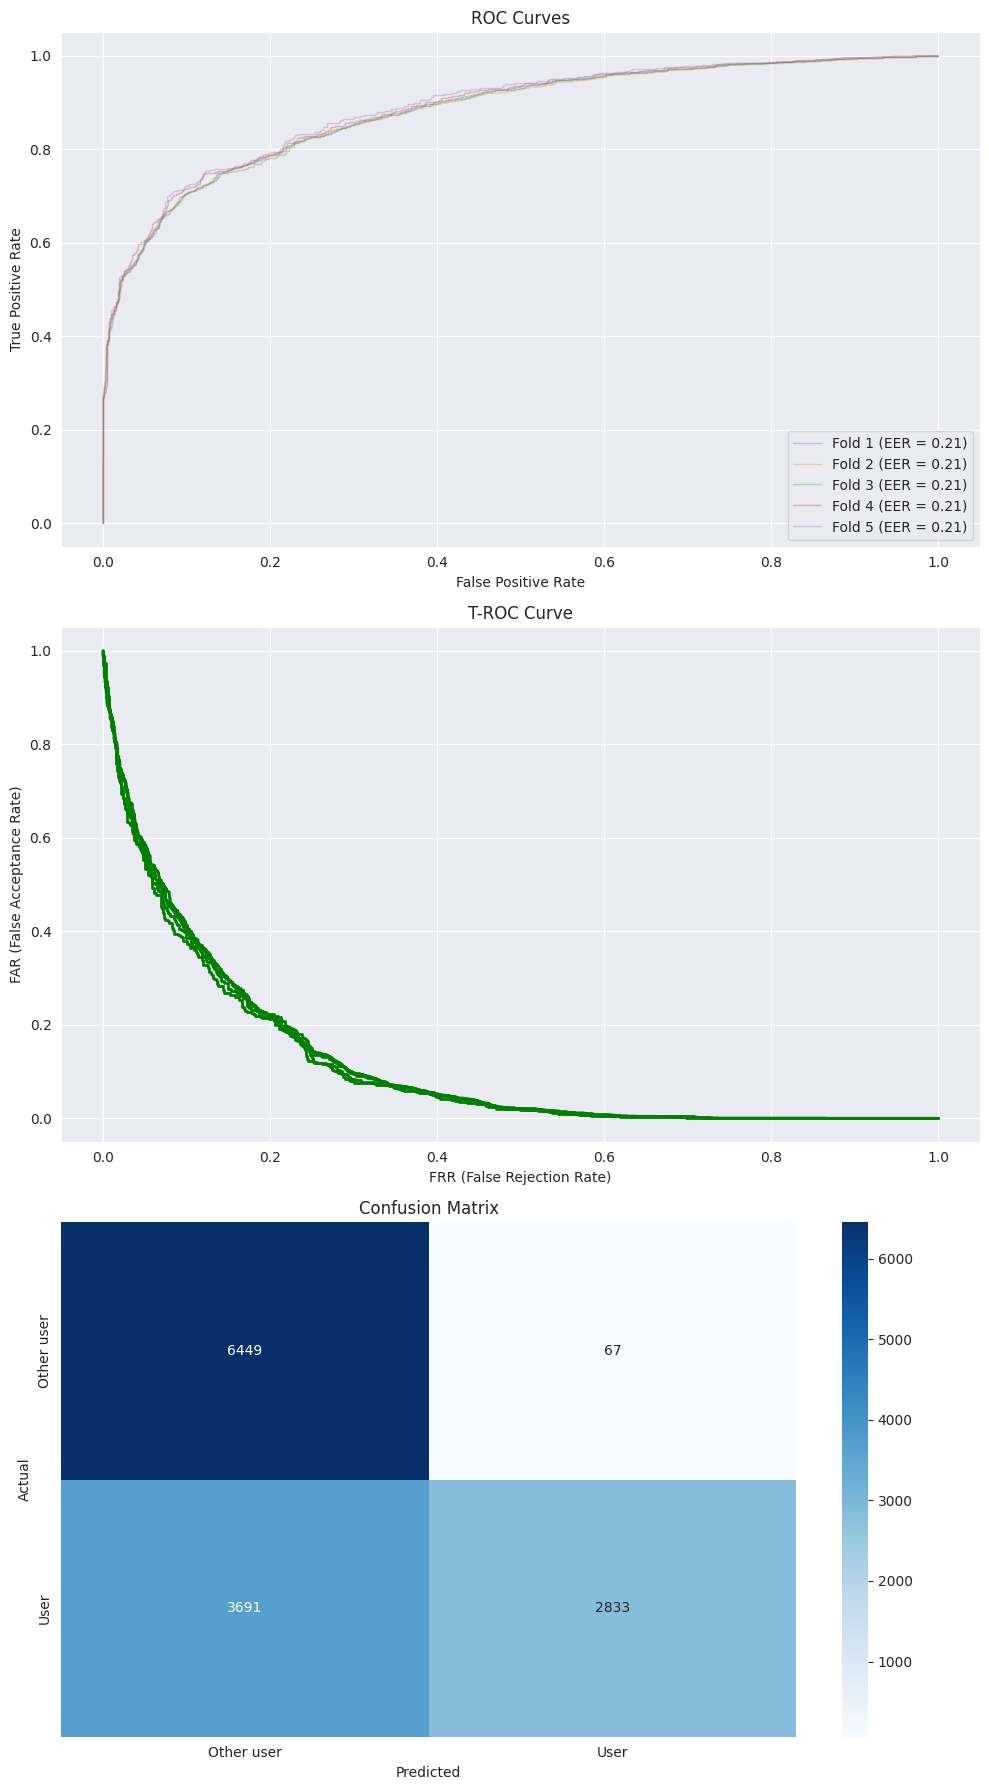

2023-09-05 01:17:18,623 — logger — INFO — X_train: (18120, 10), y_train: (18120,)
Reading training dataset...
2023-09-05 01:17:18,630 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.032420. Found 18120 examples.
2023-09-05 01:17:18,663 — absl — INFO — Training dataset read in 0:00:00.032420. Found 18120 examples.
Training model...
2023-09-05 01:17:18,664 — absl — INFO — Training model...


[INFO 23-09-05 01:17:18.7182 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.669138
2023-09-05 01:17:19,333 — absl — INFO — Model trained in 0:00:00.669138
Compiling model...
2023-09-05 01:17:19,340 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:19,452 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:19.2710 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:19.3274 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:19.3274 CEST kernel.cc:1075] Use fast generic engine


424/424 - 1s - 954ms/epoch - 2ms/step
2023-09-05 01:17:20,581 — logger — INFO — X_train: (18120, 10), y_train: (18120,)
Reading training dataset...
2023-09-05 01:17:20,587 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.045245. Found 18120 examples.
2023-09-05 01:17:20,632 — absl — INFO — Training dataset read in 0:00:00.045245. Found 18120 examples.
Training model...
2023-09-05 01:17:20,633 — absl — INFO — Training model...


[INFO 23-09-05 01:17:20.6821 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.562659
2023-09-05 01:17:21,196 — absl — INFO — Model trained in 0:00:00.562659
Compiling model...
2023-09-05 01:17:21,200 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:21,297 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:21.1491 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:21.1920 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:21.1921 CEST kernel.cc:1075] Use fast generic engine


318/318 - 1s - 541ms/epoch - 2ms/step
2023-09-05 01:17:21,975 — logger — INFO — X_train: (18120, 10), y_train: (18120,)
Reading training dataset...
2023-09-05 01:17:21,982 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.034623. Found 18120 examples.
2023-09-05 01:17:22,017 — absl — INFO — Training dataset read in 0:00:00.034623. Found 18120 examples.
Training model...
2023-09-05 01:17:22,018 — absl — INFO — Training model...


[INFO 23-09-05 01:17:22.0673 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.598967
2023-09-05 01:17:22,617 — absl — INFO — Model trained in 0:00:00.598967
Compiling model...
2023-09-05 01:17:22,621 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:22,744 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:22.5702 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:22.6136 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:22.6136 CEST kernel.cc:1075] Use fast generic engine


239/239 - 0s - 476ms/epoch - 2ms/step
2023-09-05 01:17:23,346 — logger — INFO — X_train: (18120, 10), y_train: (18120,)
Reading training dataset...
2023-09-05 01:17:23,352 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.031650. Found 18120 examples.
2023-09-05 01:17:23,383 — absl — INFO — Training dataset read in 0:00:00.031650. Found 18120 examples.
Training model...
2023-09-05 01:17:23,384 — absl — INFO — Training model...


[INFO 23-09-05 01:17:23.4352 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.611645
2023-09-05 01:17:23,996 — absl — INFO — Model trained in 0:00:00.611645
Compiling model...
2023-09-05 01:17:24,000 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:24,108 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:23.9512 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:23.9927 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:23.9927 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-05 01:17:23.9927 CEST kernel.cc:1075] Use fast generic engine


179/179 - 0s - 337ms/epoch - 2ms/step
2023-09-05 01:17:24,540 — logger — INFO — X_train: (18120, 10), y_train: (18120,)
Reading training dataset...
2023-09-05 01:17:24,545 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.033773. Found 18120 examples.
2023-09-05 01:17:24,578 — absl — INFO — Training dataset read in 0:00:00.033773. Found 18120 examples.
Training model...
2023-09-05 01:17:24,579 — absl — INFO — Training model...


[INFO 23-09-05 01:17:24.6350 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.618931
2023-09-05 01:17:25,198 — absl — INFO — Model trained in 0:00:00.618931
Compiling model...
2023-09-05 01:17:25,202 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:25,301 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:25.1503 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:25.1948 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:25.1948 CEST kernel.cc:1075] Use fast generic engine


135/135 - 0s - 253ms/epoch - 2ms/step


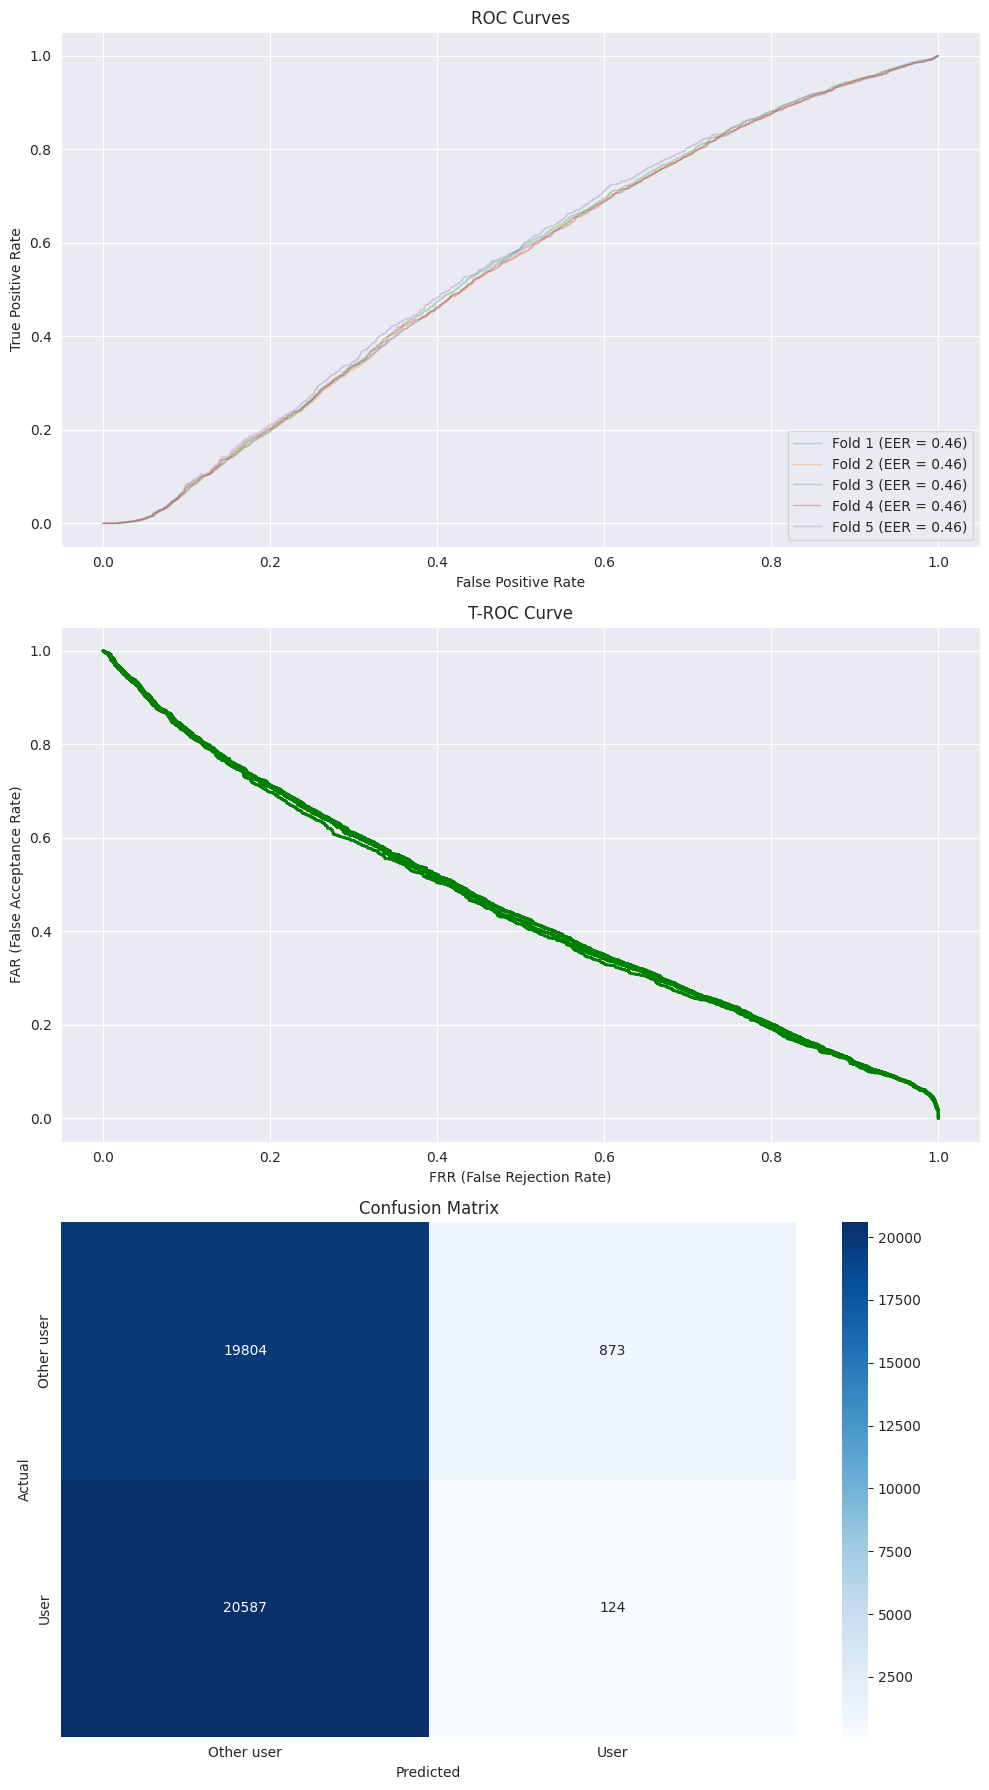

2023-09-05 01:17:26,448 — logger — INFO — X_train: (3328, 10), y_train: (3328,)
Reading training dataset...
2023-09-05 01:17:26,454 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.010458. Found 3328 examples.
2023-09-05 01:17:26,465 — absl — INFO — Training dataset read in 0:00:00.010458. Found 3328 examples.
Training model...
2023-09-05 01:17:26,466 — absl — INFO — Training model...
Model trained in 0:00:00.203075
2023-09-05 01:17:26,669 — absl — INFO — Model trained in 0:00:00.203075
Compiling model...
2023-09-05 01:17:26,675 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:26.5106 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:26.6187 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:26.6655 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:26.6656 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:26,785 — absl — INFO — Model compiled.
81/81 - 0s - 182ms/epoch - 2ms/step
2023-09-05 01:17:27,035 — logger — INFO — X_train: (3328, 10), y_train: (3328,)
Reading training dataset...
2023-09-05 01:17:27,041 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.014546. Found 3328 examples.
2023-09-05 01:17:27,055 — absl — INFO — Training dataset read in 0:00:00.014546. Found 3328 examples.
Training model...
2023-09-05 01:17:27,056 — absl — INFO — Training model...
Model trained in 0:00:00.248487
2023-09-05 01:17:27,305 — absl — INFO — Model trained in 0:00:00.248487
Compiling model...
2023-09-05 01:17:27,311 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:27.1119 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:27.2477 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:27.3003 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:27.3004 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:27,419 — absl — INFO — Model compiled.
61/61 - 0s - 141ms/epoch - 2ms/step
2023-09-05 01:17:27,617 — logger — INFO — X_train: (3328, 10), y_train: (3328,)
Reading training dataset...
2023-09-05 01:17:27,623 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.013615. Found 3328 examples.
2023-09-05 01:17:27,637 — absl — INFO — Training dataset read in 0:00:00.013615. Found 3328 examples.
Training model...
2023-09-05 01:17:27,638 — absl — INFO — Training model...


[INFO 23-09-05 01:17:27.7025 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:27.8385 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:27.9006 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:27.9007 CEST kernel.cc:1075] Use fast generic engine


Model trained in 0:00:00.267609
2023-09-05 01:17:27,905 — absl — INFO — Model trained in 0:00:00.267609
Compiling model...
2023-09-05 01:17:27,911 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:28,033 — absl — INFO — Model compiled.
46/46 - 0s - 113ms/epoch - 2ms/step
2023-09-05 01:17:28,201 — logger — INFO — X_train: (3328, 10), y_train: (3328,)
Reading training dataset...
2023-09-05 01:17:28,207 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.013480. Found 3328 examples.
2023-09-05 01:17:28,220 — absl — INFO — Training dataset read in 0:00:00.013480. Found 3328 examples.
Training model...
2023-09-05 01:17:28,221 — absl — INFO — Training model...
Model trained in 0:00:00.213497
2023-09-05 01:17:28,435 — absl — INFO — Model trained in 0:00:00.213497
Compiling model...
2023-09-05 01:17:28,439 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:28.2738 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:28.3859 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:28.4313 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:28.4313 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:28,570 — absl — INFO — Model compiled.
34/34 - 0s - 111ms/epoch - 3ms/step
2023-09-05 01:17:28,764 — logger — INFO — X_train: (3328, 10), y_train: (3328,)
Reading training dataset...
2023-09-05 01:17:28,770 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.011549. Found 3328 examples.
2023-09-05 01:17:28,781 — absl — INFO — Training dataset read in 0:00:00.011549. Found 3328 examples.
Training model...
2023-09-05 01:17:28,782 — absl — INFO — Training model...
Model trained in 0:00:00.231377
2023-09-05 01:17:29,014 — absl — INFO — Model trained in 0:00:00.231377
Compiling model...
2023-09-05 01:17:29,020 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:28.8373 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:28.9607 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:29.0090 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:29.0090 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:29,141 — absl — INFO — Model compiled.
26/26 - 0s - 85ms/epoch - 3ms/step


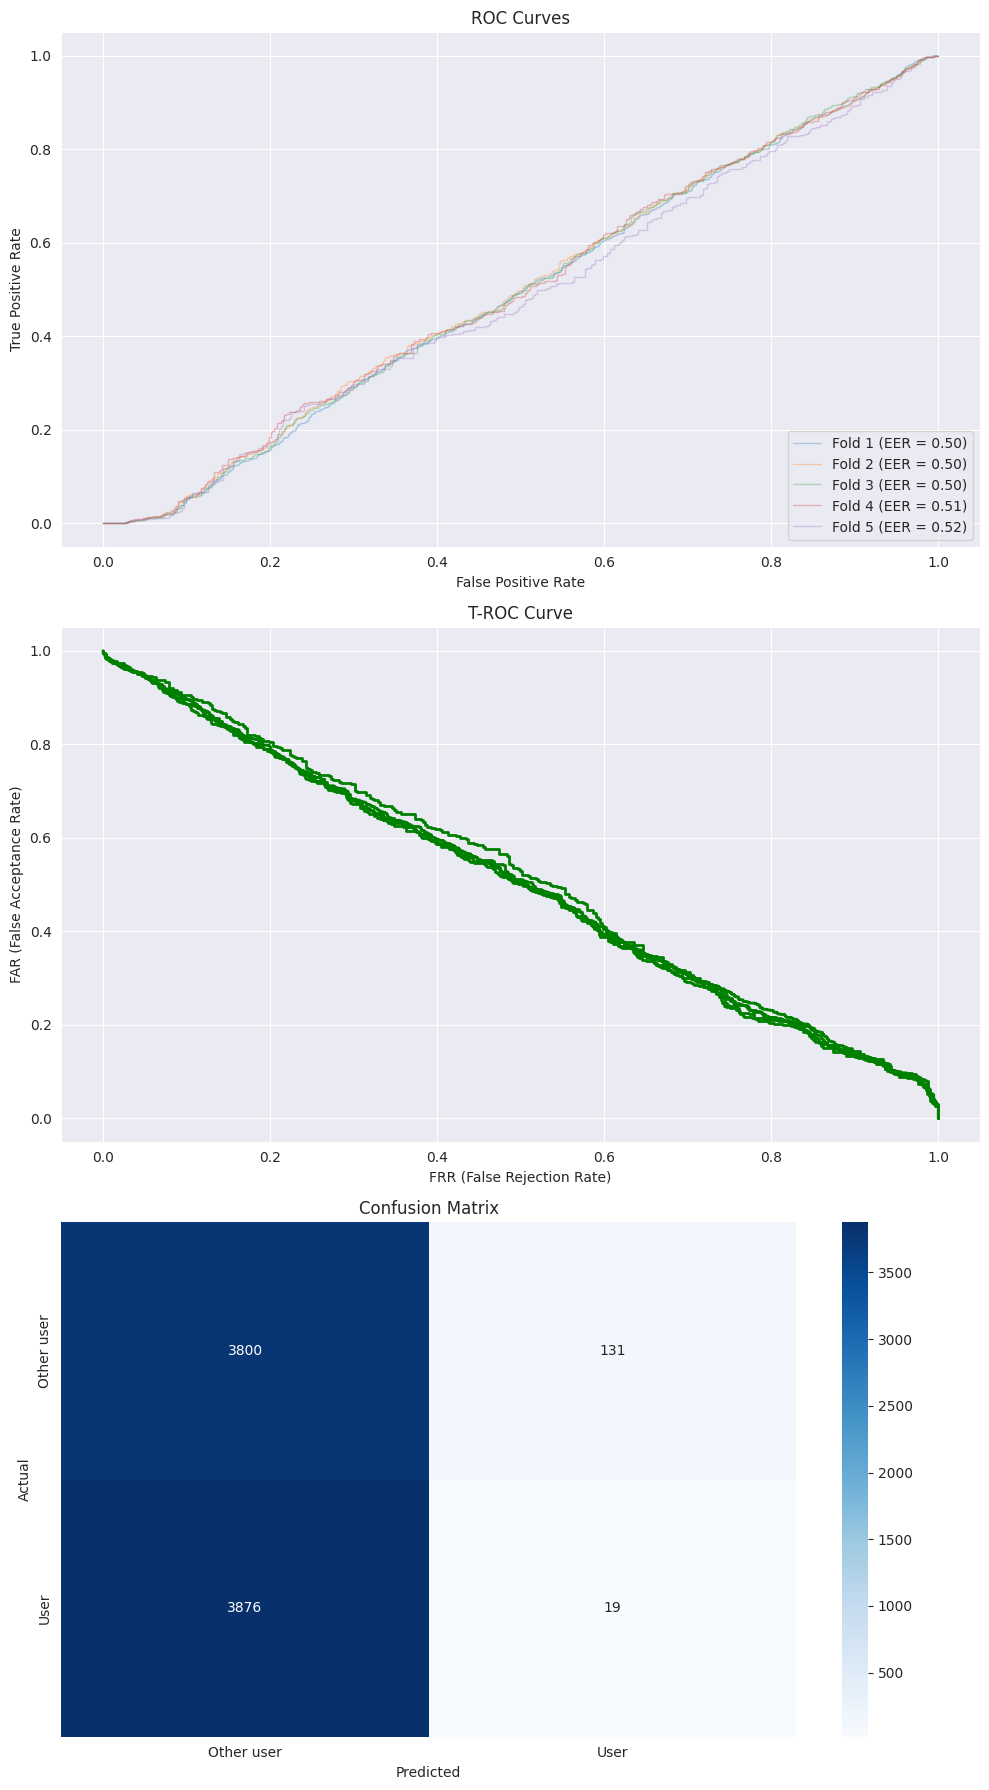

2023-09-05 01:17:30,683 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:17:30,689 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008463. Found 696 examples.
2023-09-05 01:17:30,697 — absl — INFO — Training dataset read in 0:00:00.008463. Found 696 examples.
Training model...
2023-09-05 01:17:30,698 — absl — INFO — Training model...
Model trained in 0:00:00.191837
2023-09-05 01:17:30,890 — absl — INFO — Model trained in 0:00:00.191837
Compiling model...
2023-09-05 01:17:30,901 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:30.7666 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:30.8143 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:30.8825 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:30.8825 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:31,043 — absl — INFO — Model compiled.
22/22 - 0s - 134ms/epoch - 6ms/step
2023-09-05 01:17:31,303 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:17:31,310 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.010927. Found 696 examples.
2023-09-05 01:17:31,321 — absl — INFO — Training dataset read in 0:00:00.010927. Found 696 examples.
Training model...
2023-09-05 01:17:31,322 — absl — INFO — Training model...
Model trained in 0:00:00.188042
2023-09-05 01:17:31,510 — absl — INFO — Model trained in 0:00:00.188042
Compiling model...
2023-09-05 01:17:31,519 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:31.3826 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:31.4364 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:31.4990 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:31.4991 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:31,652 — absl — INFO — Model compiled.
17/17 - 0s - 67ms/epoch - 4ms/step
2023-09-05 01:17:31,767 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:17:31,772 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007690. Found 696 examples.
2023-09-05 01:17:31,780 — absl — INFO — Training dataset read in 0:00:00.007690. Found 696 examples.
Training model...
2023-09-05 01:17:31,781 — absl — INFO — Training model...
Model trained in 0:00:00.148494
2023-09-05 01:17:31,929 — absl — INFO — Model trained in 0:00:00.148494
Compiling model...
2023-09-05 01:17:31,936 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:31.8289 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:31.8771 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:31.9250 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:31.9251 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:32,036 — absl — INFO — Model compiled.
13/13 - 0s - 63ms/epoch - 5ms/step
2023-09-05 01:17:32,144 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:17:32,148 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006484. Found 696 examples.
2023-09-05 01:17:32,155 — absl — INFO — Training dataset read in 0:00:00.006484. Found 696 examples.
Training model...
2023-09-05 01:17:32,155 — absl — INFO — Training model...
Model trained in 0:00:00.131890
2023-09-05 01:17:32,288 — absl — INFO — Model trained in 0:00:00.131890
Compiling model...
2023-09-05 01:17:32,294 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:32,398 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:32.2034 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:32.2406 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:32.2841 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:32.2841 CEST kernel.cc:1075] Use fast generic engine


10/10 - 0s - 67ms/epoch - 7ms/step
2023-09-05 01:17:32,512 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:17:32,517 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006813. Found 696 examples.
2023-09-05 01:17:32,524 — absl — INFO — Training dataset read in 0:00:00.006813. Found 696 examples.
Training model...
2023-09-05 01:17:32,524 — absl — INFO — Training model...
Model trained in 0:00:00.135064
2023-09-05 01:17:32,659 — absl — INFO — Model trained in 0:00:00.135064
Compiling model...
2023-09-05 01:17:32,665 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:32,759 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:32.5717 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:32.6112 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:32.6557 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:32.6558 CEST kernel.cc:1075] Use fast generic engine


7/7 - 0s - 61ms/epoch - 9ms/step


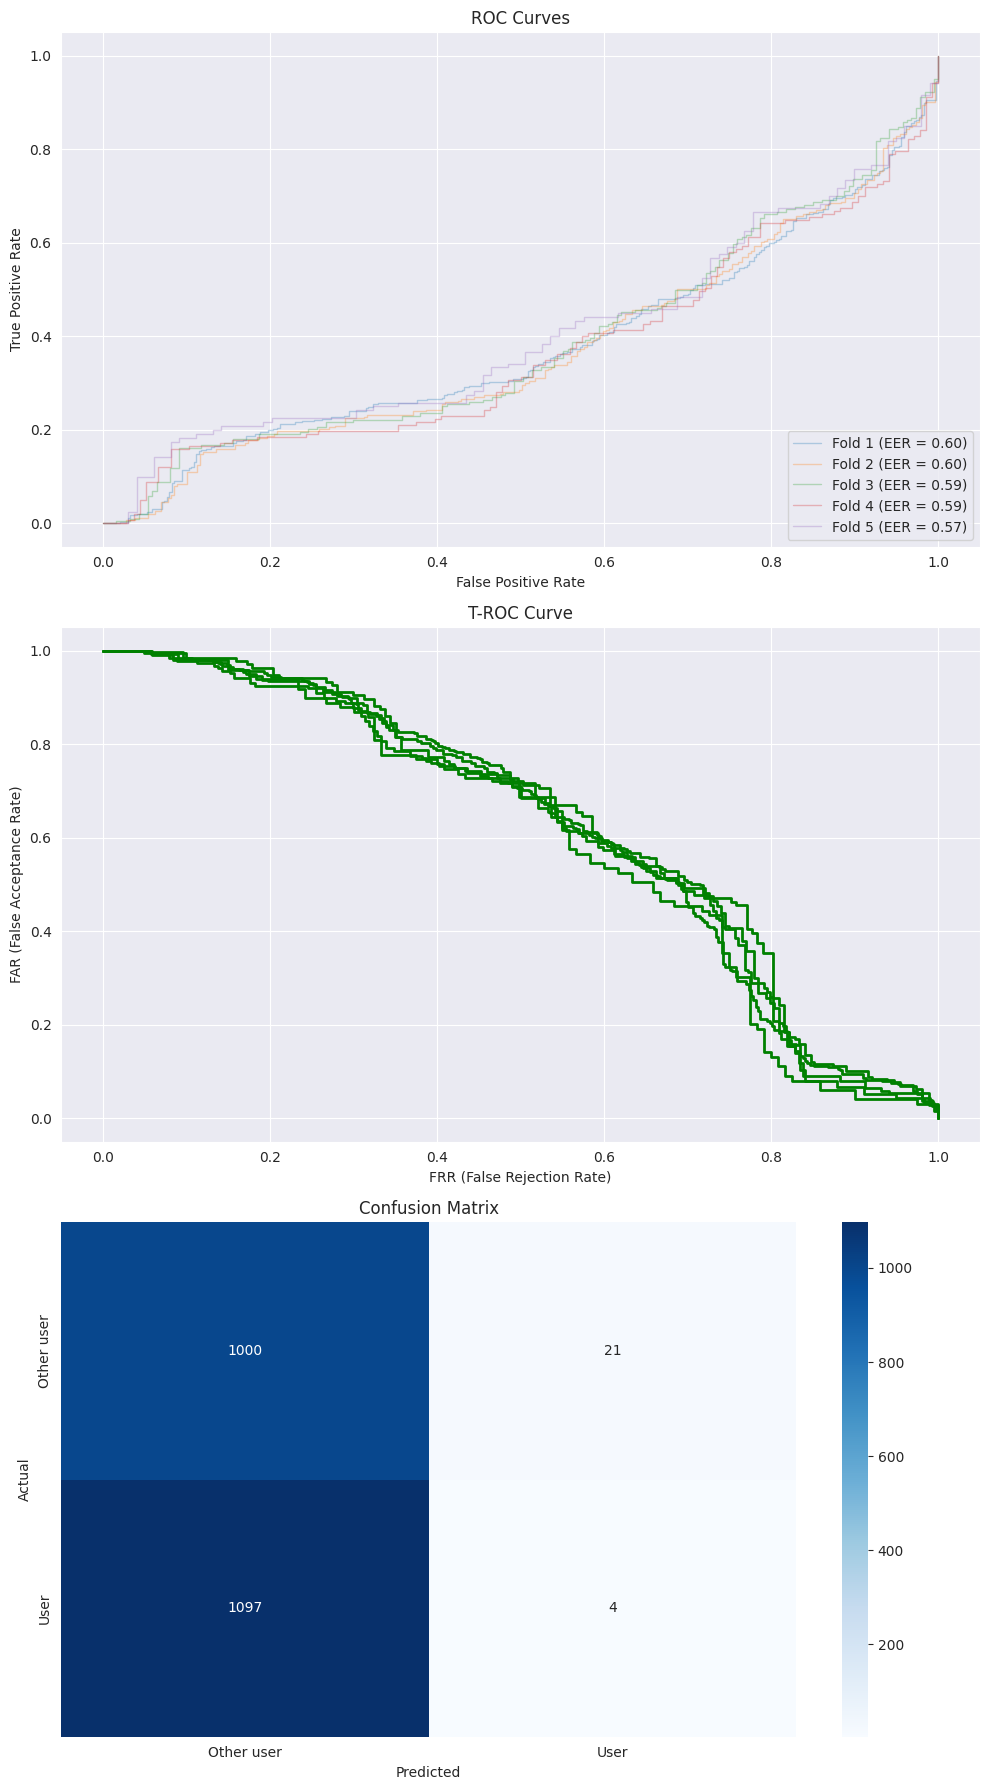

2023-09-05 01:17:33,555 — logger — INFO — X_train: (2121, 10), y_train: (2121,)
Reading training dataset...
2023-09-05 01:17:33,560 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.009813. Found 2121 examples.
2023-09-05 01:17:33,570 — absl — INFO — Training dataset read in 0:00:00.009813. Found 2121 examples.
Training model...
2023-09-05 01:17:33,571 — absl — INFO — Training model...
Model trained in 0:00:00.181107
2023-09-05 01:17:33,752 — absl — INFO — Model trained in 0:00:00.181107
Compiling model...
2023-09-05 01:17:33,757 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:33.6236 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:33.7061 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:33.7486 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:33.7486 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:33,864 — absl — INFO — Model compiled.
47/47 - 0s - 113ms/epoch - 2ms/step
2023-09-05 01:17:34,038 — logger — INFO — X_train: (2121, 10), y_train: (2121,)
Reading training dataset...
2023-09-05 01:17:34,043 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008343. Found 2121 examples.
2023-09-05 01:17:34,052 — absl — INFO — Training dataset read in 0:00:00.008343. Found 2121 examples.
Training model...
2023-09-05 01:17:34,052 — absl — INFO — Training model...
Model trained in 0:00:00.176156
2023-09-05 01:17:34,228 — absl — INFO — Model trained in 0:00:00.176156
Compiling model...
2023-09-05 01:17:34,233 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:34.1092 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:34.1802 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:34.2242 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:34.2243 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-05 01:17:34.2243 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:34,346 — absl — INFO — Model compiled.
35/35 - 0s - 98ms/epoch - 3ms/step
2023-09-05 01:17:34,499 — logger — INFO — X_train: (2122, 10), y_train: (2122,)
Reading training dataset...
2023-09-05 01:17:34,504 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008033. Found 2122 examples.
2023-09-05 01:17:34,512 — absl — INFO — Training dataset read in 0:00:00.008033. Found 2122 examples.
Training model...
2023-09-05 01:17:34,513 — absl — INFO — Training model...
Model trained in 0:00:00.182228
2023-09-05 01:17:34,695 — absl — INFO — Model trained in 0:00:00.182228
Compiling model...
2023-09-05 01:17:34,700 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:34.5616 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:34.6410 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:34.6919 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:34.6919 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:34,806 — absl — INFO — Model compiled.
27/27 - 0s - 93ms/epoch - 3ms/step
2023-09-05 01:17:34,948 — logger — INFO — X_train: (2122, 10), y_train: (2122,)
Reading training dataset...
2023-09-05 01:17:34,952 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007842. Found 2122 examples.
2023-09-05 01:17:34,960 — absl — INFO — Training dataset read in 0:00:00.007842. Found 2122 examples.
Training model...
2023-09-05 01:17:34,961 — absl — INFO — Training model...
Model trained in 0:00:00.177071
2023-09-05 01:17:35,138 — absl — INFO — Model trained in 0:00:00.177071
Compiling model...
2023-09-05 01:17:35,143 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:35.0127 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:35.0935 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:35.1350 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:35.1350 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:35,247 — absl — INFO — Model compiled.
20/20 - 0s - 78ms/epoch - 4ms/step
2023-09-05 01:17:35,376 — logger — INFO — X_train: (2122, 10), y_train: (2122,)
Reading training dataset...
2023-09-05 01:17:35,381 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007788. Found 2122 examples.
2023-09-05 01:17:35,389 — absl — INFO — Training dataset read in 0:00:00.007788. Found 2122 examples.
Training model...
2023-09-05 01:17:35,390 — absl — INFO — Training model...
Model trained in 0:00:00.174936
2023-09-05 01:17:35,565 — absl — INFO — Model trained in 0:00:00.174936
Compiling model...
2023-09-05 01:17:35,568 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:35.4386 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:35.5178 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:35.5614 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:35.5614 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:35,671 — absl — INFO — Model compiled.
15/15 - 0s - 63ms/epoch - 4ms/step


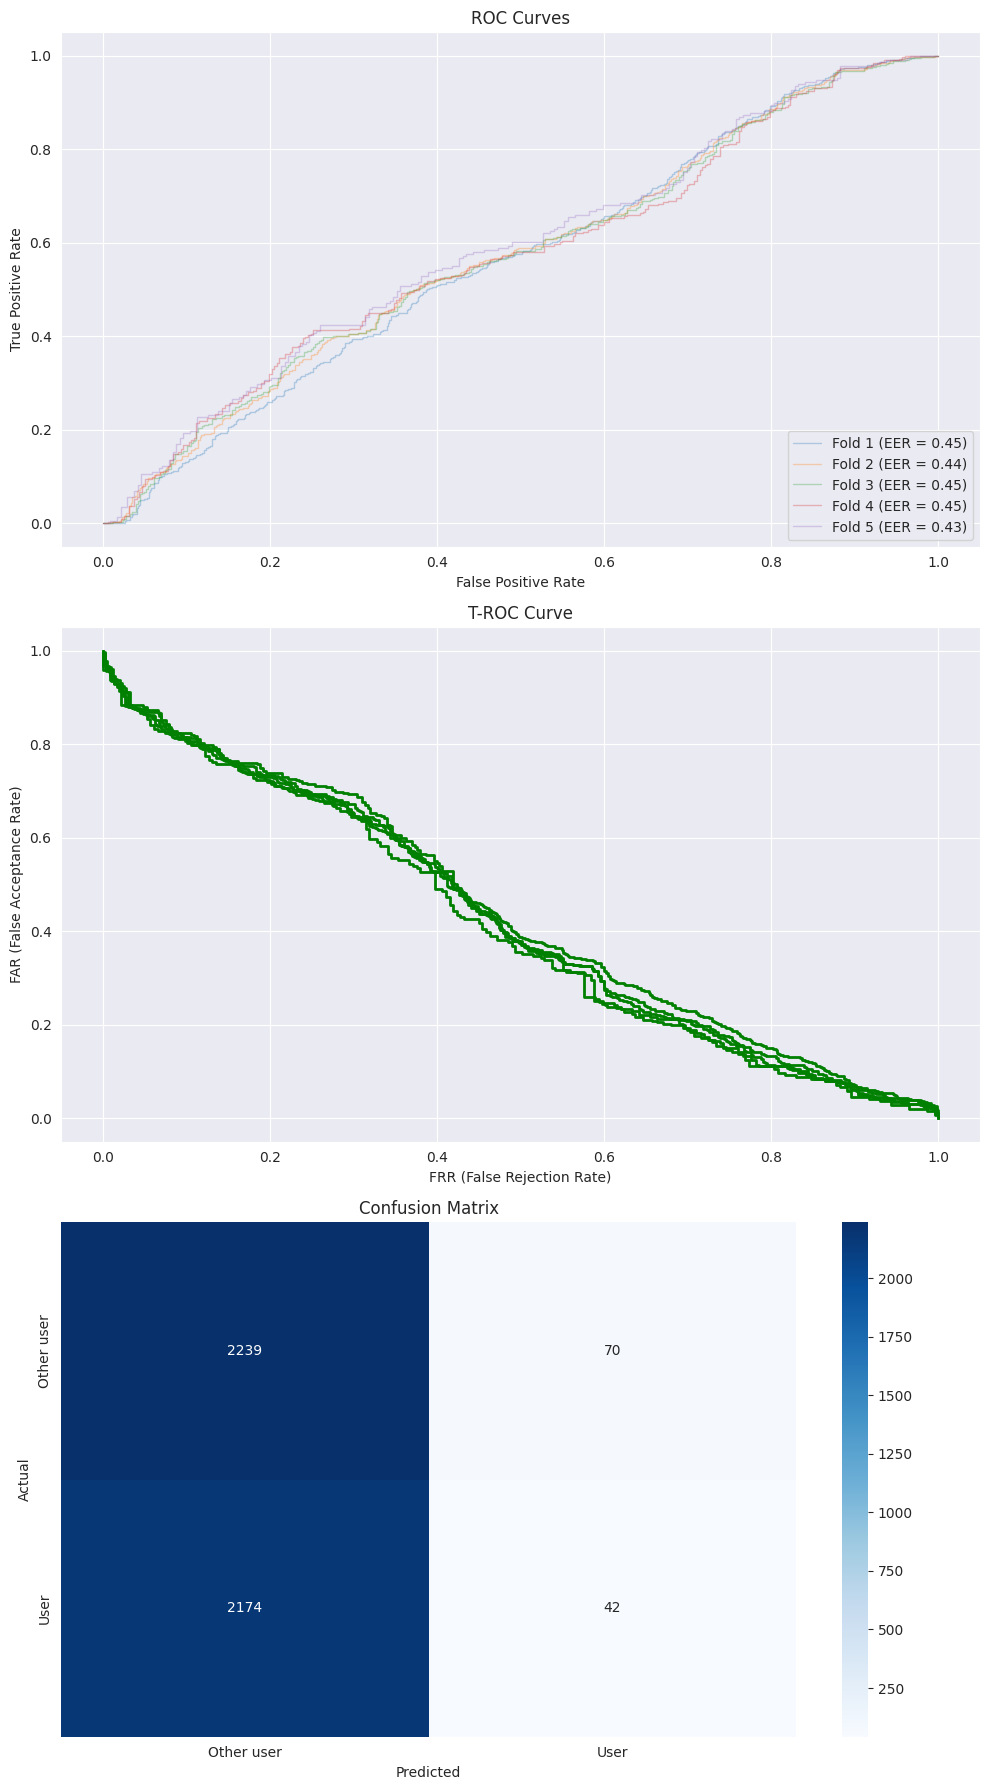

2023-09-05 01:17:36,660 — logger — INFO — X_train: (168, 10), y_train: (168,)
Reading training dataset...
2023-09-05 01:17:36,664 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006745. Found 168 examples.
2023-09-05 01:17:36,671 — absl — INFO — Training dataset read in 0:00:00.006745. Found 168 examples.
Training model...
2023-09-05 01:17:36,672 — absl — INFO — Training model...
Model trained in 0:00:00.119331
2023-09-05 01:17:36,791 — absl — INFO — Model trained in 0:00:00.119331
Compiling model...
2023-09-05 01:17:36,796 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:36,872 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:36.7186 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:36.7462 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:36.7881 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:36.7881 CEST kernel.cc:1075] Use fast generic engine


5/5 - 0s - 62ms/epoch - 12ms/step
2023-09-05 01:17:36,979 — logger — INFO — X_train: (168, 10), y_train: (168,)
Reading training dataset...
2023-09-05 01:17:36,985 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007279. Found 168 examples.
2023-09-05 01:17:36,993 — absl — INFO — Training dataset read in 0:00:00.007279. Found 168 examples.
Training model...
2023-09-05 01:17:36,993 — absl — INFO — Training model...
Model trained in 0:00:00.130002
2023-09-05 01:17:37,123 — absl — INFO — Model trained in 0:00:00.130002
Compiling model...
2023-09-05 01:17:37,124 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:37,205 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:37.0443 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:37.0712 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:37.1168 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:37.1169 CEST kernel.cc:1075] Use fast generic engine


4/4 - 0s - 50ms/epoch - 13ms/step
2023-09-05 01:17:37,299 — logger — INFO — X_train: (168, 10), y_train: (168,)
Reading training dataset...
2023-09-05 01:17:37,304 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007062. Found 168 examples.
2023-09-05 01:17:37,311 — absl — INFO — Training dataset read in 0:00:00.007062. Found 168 examples.
Training model...
2023-09-05 01:17:37,312 — absl — INFO — Training model...
Model trained in 0:00:00.149981
2023-09-05 01:17:37,462 — absl — INFO — Model trained in 0:00:00.149981
Compiling model...
2023-09-05 01:17:37,467 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:37,556 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:37.3616 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:37.3999 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:37.4569 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:37.4570 CEST kernel.cc:1075] Use fast generic engine


3/3 - 0s - 47ms/epoch - 16ms/step
2023-09-05 01:17:37,642 — logger — INFO — X_train: (168, 10), y_train: (168,)
Reading training dataset...
2023-09-05 01:17:37,647 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.005831. Found 168 examples.
2023-09-05 01:17:37,653 — absl — INFO — Training dataset read in 0:00:00.005831. Found 168 examples.
Training model...
2023-09-05 01:17:37,653 — absl — INFO — Training model...
Model trained in 0:00:00.124901
2023-09-05 01:17:37,778 — absl — INFO — Model trained in 0:00:00.124901
Compiling model...
2023-09-05 01:17:37,783 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:37,868 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:37.7039 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:37.7326 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:37.7753 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:37.7753 CEST kernel.cc:1075] Use fast generic engine


3/3 - 0s - 46ms/epoch - 15ms/step
2023-09-05 01:17:37,955 — logger — INFO — X_train: (168, 10), y_train: (168,)
Reading training dataset...
2023-09-05 01:17:37,960 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006611. Found 168 examples.
2023-09-05 01:17:37,967 — absl — INFO — Training dataset read in 0:00:00.006611. Found 168 examples.
Training model...
2023-09-05 01:17:37,968 — absl — INFO — Training model...
Model trained in 0:00:00.125758
2023-09-05 01:17:38,094 — absl — INFO — Model trained in 0:00:00.125758
Compiling model...
2023-09-05 01:17:38,098 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:38,180 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:38.0201 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:38.0475 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:38.0900 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:38.0901 CEST kernel.cc:1075] Use fast generic engine


2/2 - 0s - 45ms/epoch - 22ms/step


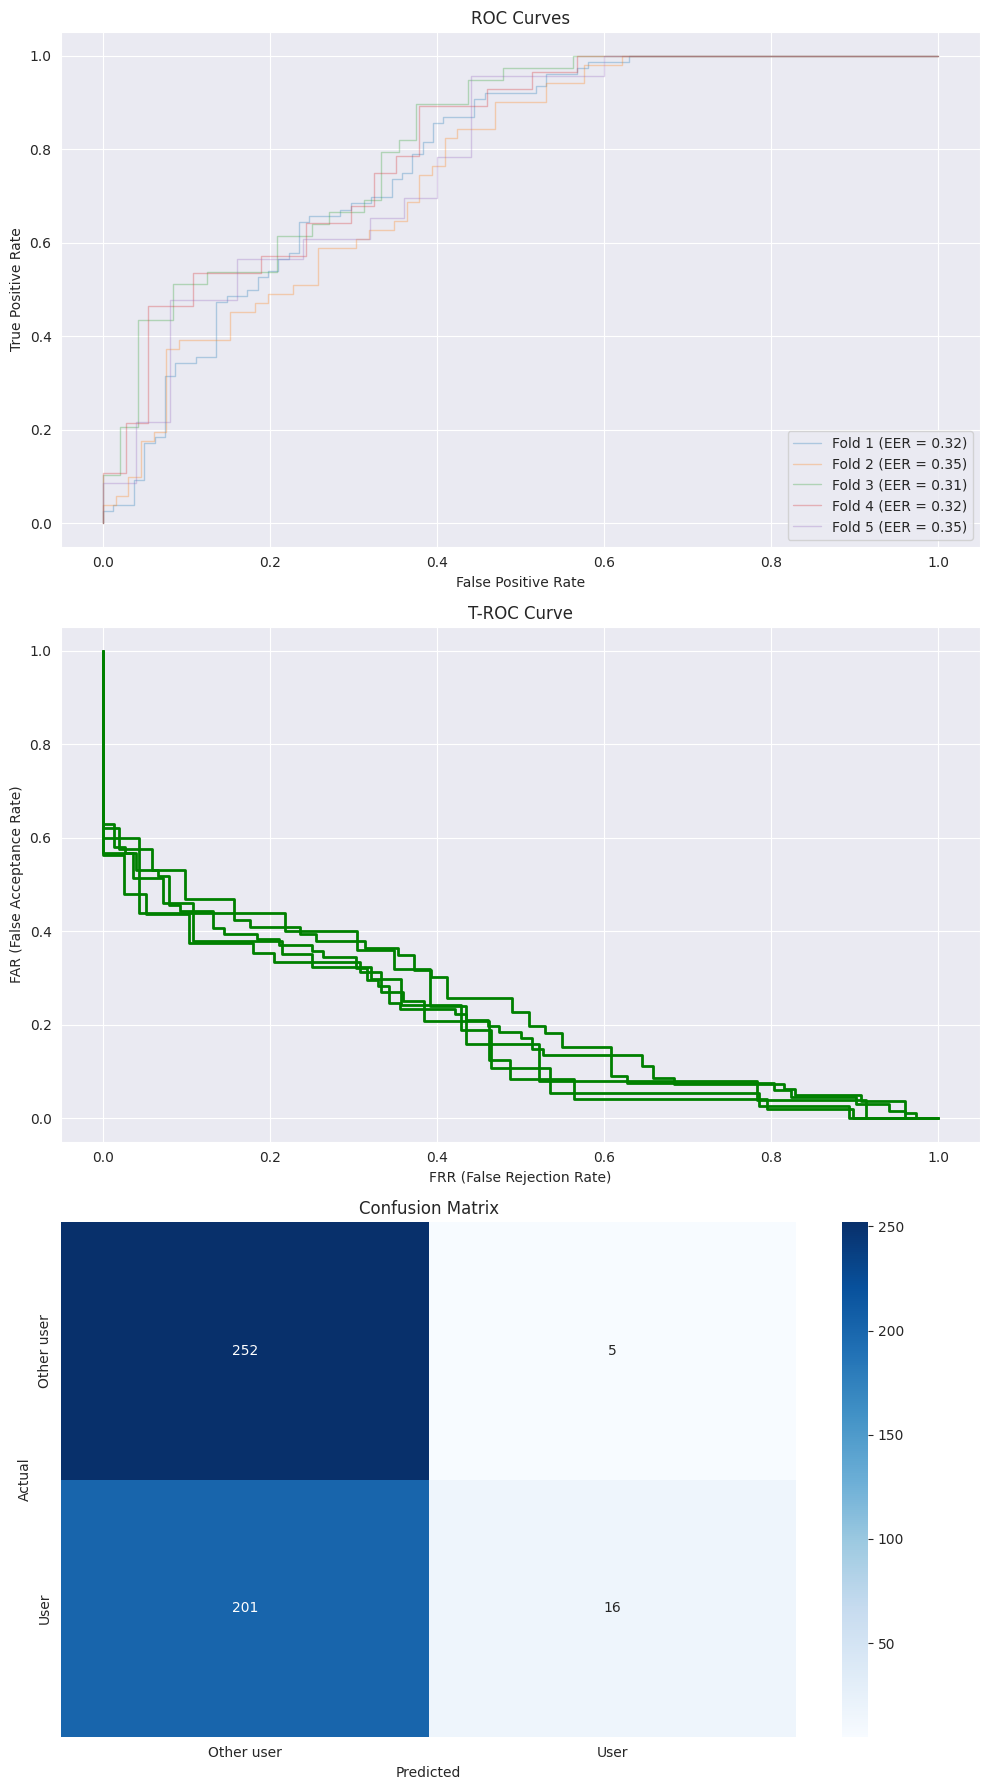

2023-09-05 01:17:39,004 — logger — INFO — X_train: (1584, 10), y_train: (1584,)
Reading training dataset...
2023-09-05 01:17:39,011 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.012936. Found 1584 examples.
2023-09-05 01:17:39,024 — absl — INFO — Training dataset read in 0:00:00.012936. Found 1584 examples.
Training model...
2023-09-05 01:17:39,025 — absl — INFO — Training model...
Model trained in 0:00:00.192274
2023-09-05 01:17:39,217 — absl — INFO — Model trained in 0:00:00.192274
Compiling model...
2023-09-05 01:17:39,222 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:39.1016 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:39.1673 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:39.2136 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:39.2136 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:39,330 — absl — INFO — Model compiled.
101/101 - 0s - 240ms/epoch - 2ms/step
2023-09-05 01:17:39,645 — logger — INFO — X_train: (1584, 10), y_train: (1584,)
Reading training dataset...
2023-09-05 01:17:39,651 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008335. Found 1584 examples.
2023-09-05 01:17:39,659 — absl — INFO — Training dataset read in 0:00:00.008335. Found 1584 examples.
Training model...
2023-09-05 01:17:39,660 — absl — INFO — Training model...
Model trained in 0:00:00.152892
2023-09-05 01:17:39,813 — absl — INFO — Model trained in 0:00:00.152892
Compiling model...
2023-09-05 01:17:39,817 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:39.7071 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:39.7648 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:39.8093 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:39.8094 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:39,934 — absl — INFO — Model compiled.
76/76 - 0s - 207ms/epoch - 3ms/step
2023-09-05 01:17:40,210 — logger — INFO — X_train: (1584, 10), y_train: (1584,)
Reading training dataset...
2023-09-05 01:17:40,216 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007979. Found 1584 examples.
2023-09-05 01:17:40,224 — absl — INFO — Training dataset read in 0:00:00.007979. Found 1584 examples.
Training model...
2023-09-05 01:17:40,226 — absl — INFO — Training model...
Model trained in 0:00:00.197807
2023-09-05 01:17:40,423 — absl — INFO — Model trained in 0:00:00.197807
Compiling model...
2023-09-05 01:17:40,429 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:40.2753 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:40.3471 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:40.4176 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:40.4177 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:40,574 — absl — INFO — Model compiled.
57/57 - 0s - 144ms/epoch - 3ms/step
2023-09-05 01:17:40,776 — logger — INFO — X_train: (1584, 10), y_train: (1584,)
Reading training dataset...
2023-09-05 01:17:40,782 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.009170. Found 1584 examples.
2023-09-05 01:17:40,791 — absl — INFO — Training dataset read in 0:00:00.009170. Found 1584 examples.
Training model...
2023-09-05 01:17:40,792 — absl — INFO — Training model...
Model trained in 0:00:00.208188
2023-09-05 01:17:41,000 — absl — INFO — Model trained in 0:00:00.208188
Compiling model...
2023-09-05 01:17:41,006 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:40.8589 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:40.9395 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:40.9953 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:40.9953 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:41,124 — absl — INFO — Model compiled.
43/43 - 0s - 119ms/epoch - 3ms/step
2023-09-05 01:17:41,296 — logger — INFO — X_train: (1584, 10), y_train: (1584,)
Reading training dataset...
2023-09-05 01:17:41,300 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008295. Found 1584 examples.
2023-09-05 01:17:41,309 — absl — INFO — Training dataset read in 0:00:00.008295. Found 1584 examples.
Training model...
2023-09-05 01:17:41,310 — absl — INFO — Training model...
Model trained in 0:00:00.162848
2023-09-05 01:17:41,472 — absl — INFO — Model trained in 0:00:00.162848
Compiling model...
2023-09-05 01:17:41,477 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:41.3610 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:41.4274 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:41.4693 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:41.4693 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:41,607 — absl — INFO — Model compiled.
32/32 - 0s - 147ms/epoch - 5ms/step


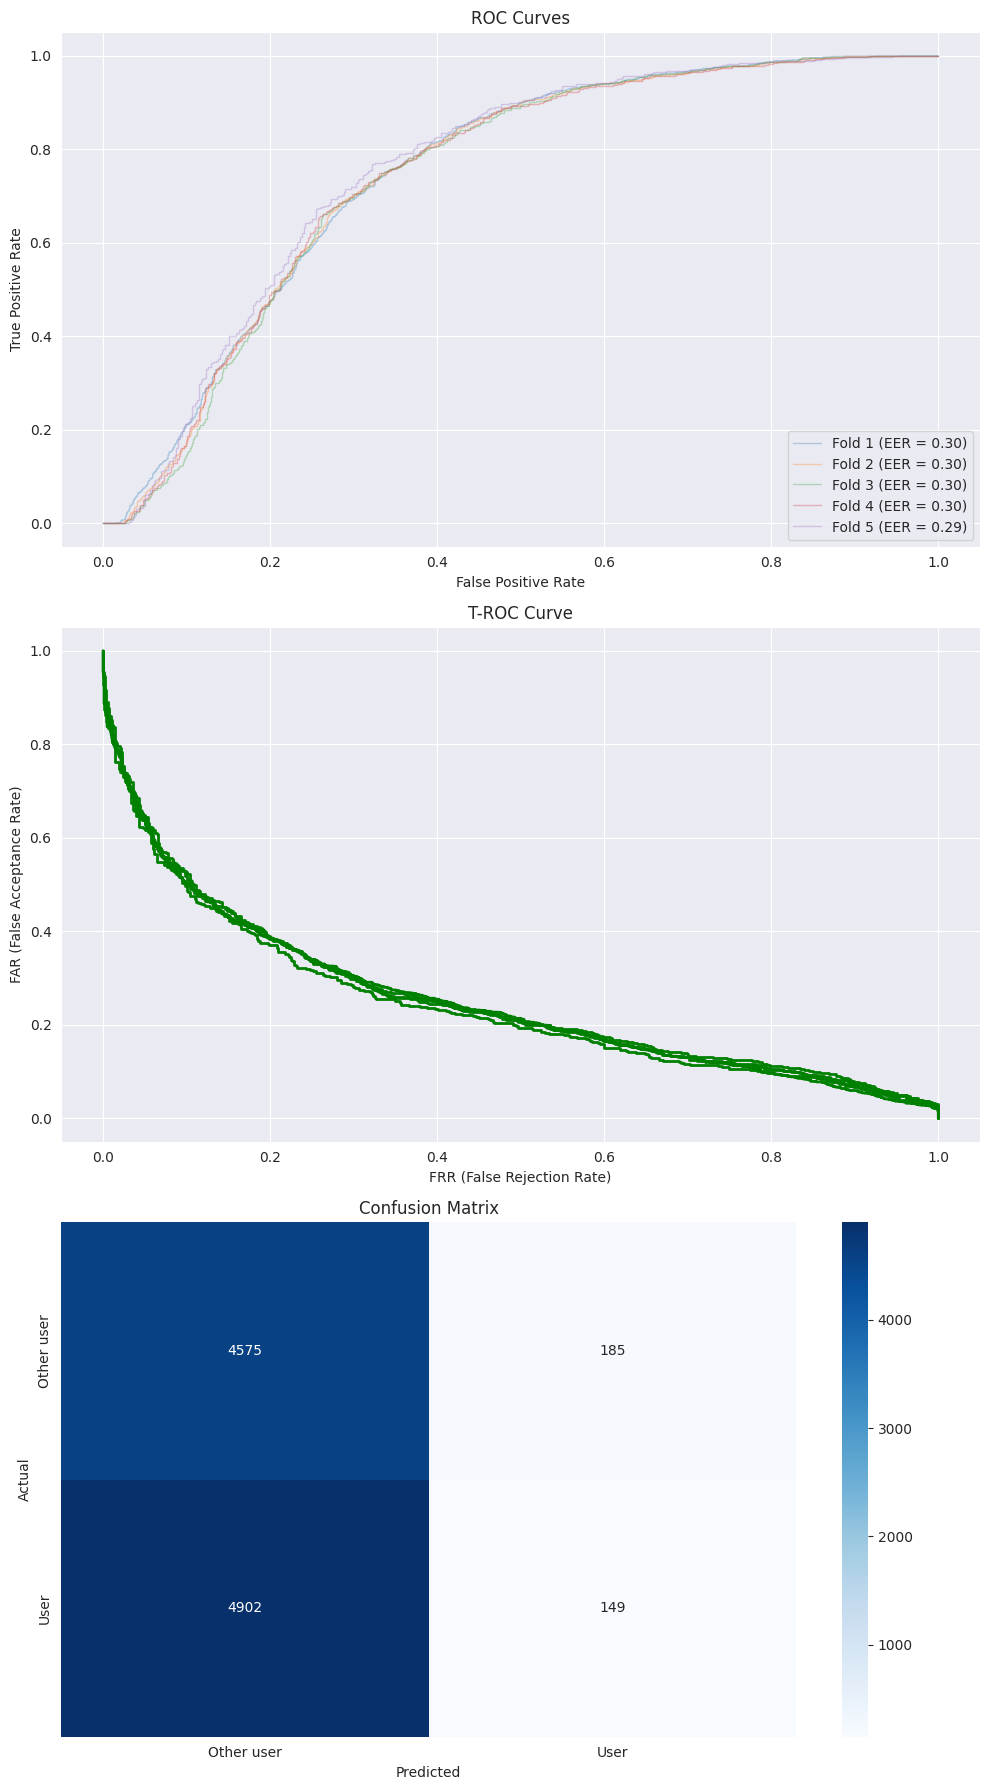

2023-09-05 01:17:42,814 — logger — INFO — X_train: (18604, 10), y_train: (18604,)
Reading training dataset...
2023-09-05 01:17:42,821 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.029026. Found 18604 examples.
2023-09-05 01:17:42,850 — absl — INFO — Training dataset read in 0:00:00.029026. Found 18604 examples.
Training model...
2023-09-05 01:17:42,851 — absl — INFO — Training model...


[INFO 23-09-05 01:17:42.9059 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.619268
2023-09-05 01:17:43,470 — absl — INFO — Model trained in 0:00:00.619268
Compiling model...
2023-09-05 01:17:43,475 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:43,576 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:43.4241 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:43.4667 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:43.4667 CEST kernel.cc:1075] Use fast generic engine


517/517 - 1s - 855ms/epoch - 2ms/step
2023-09-05 01:17:44,618 — logger — INFO — X_train: (18605, 10), y_train: (18605,)
Reading training dataset...
2023-09-05 01:17:44,624 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.043105. Found 18605 examples.
2023-09-05 01:17:44,668 — absl — INFO — Training dataset read in 0:00:00.043105. Found 18605 examples.
Training model...
2023-09-05 01:17:44,669 — absl — INFO — Training model...


[INFO 23-09-05 01:17:44.7255 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.644609
2023-09-05 01:17:45,313 — absl — INFO — Model trained in 0:00:00.644609
Compiling model...
2023-09-05 01:17:45,319 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:45,446 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:45.2590 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:45.3084 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:45.3085 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-05 01:17:45.3085 CEST kernel.cc:1075] Use fast generic engine


388/388 - 1s - 657ms/epoch - 2ms/step
2023-09-05 01:17:46,261 — logger — INFO — X_train: (18605, 10), y_train: (18605,)
Reading training dataset...
2023-09-05 01:17:46,267 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.047020. Found 18605 examples.
2023-09-05 01:17:46,314 — absl — INFO — Training dataset read in 0:00:00.047020. Found 18605 examples.
Training model...
2023-09-05 01:17:46,315 — absl — INFO — Training model...


[INFO 23-09-05 01:17:46.3738 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.632421
2023-09-05 01:17:46,948 — absl — INFO — Model trained in 0:00:00.632421
Compiling model...
2023-09-05 01:17:46,952 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:47,056 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:46.9015 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:46.9435 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:46.9436 CEST kernel.cc:1075] Use fast generic engine


291/291 - 1s - 546ms/epoch - 2ms/step
2023-09-05 01:17:47,777 — logger — INFO — X_train: (18605, 10), y_train: (18605,)
Reading training dataset...
2023-09-05 01:17:47,784 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.041587. Found 18605 examples.
2023-09-05 01:17:47,826 — absl — INFO — Training dataset read in 0:00:00.041587. Found 18605 examples.
Training model...
2023-09-05 01:17:47,826 — absl — INFO — Training model...


[INFO 23-09-05 01:17:47.8931 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.688550
2023-09-05 01:17:48,515 — absl — INFO — Model trained in 0:00:00.688550
Compiling model...
2023-09-05 01:17:48,520 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:48,631 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:48.4400 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:48.5063 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:48.5063 CEST kernel.cc:1075] Use fast generic engine


219/219 - 0s - 423ms/epoch - 2ms/step
2023-09-05 01:17:49,180 — logger — INFO — X_train: (18605, 10), y_train: (18605,)
Reading training dataset...
2023-09-05 01:17:49,187 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.032120. Found 18605 examples.
2023-09-05 01:17:49,220 — absl — INFO — Training dataset read in 0:00:00.032120. Found 18605 examples.
Training model...
2023-09-05 01:17:49,221 — absl — INFO — Training model...


[INFO 23-09-05 01:17:49.2797 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.681069
2023-09-05 01:17:49,902 — absl — INFO — Model trained in 0:00:00.681069
Compiling model...
2023-09-05 01:17:49,906 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:50,015 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:49.8441 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:49.8981 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:49.8981 CEST kernel.cc:1075] Use fast generic engine


164/164 - 0s - 350ms/epoch - 2ms/step


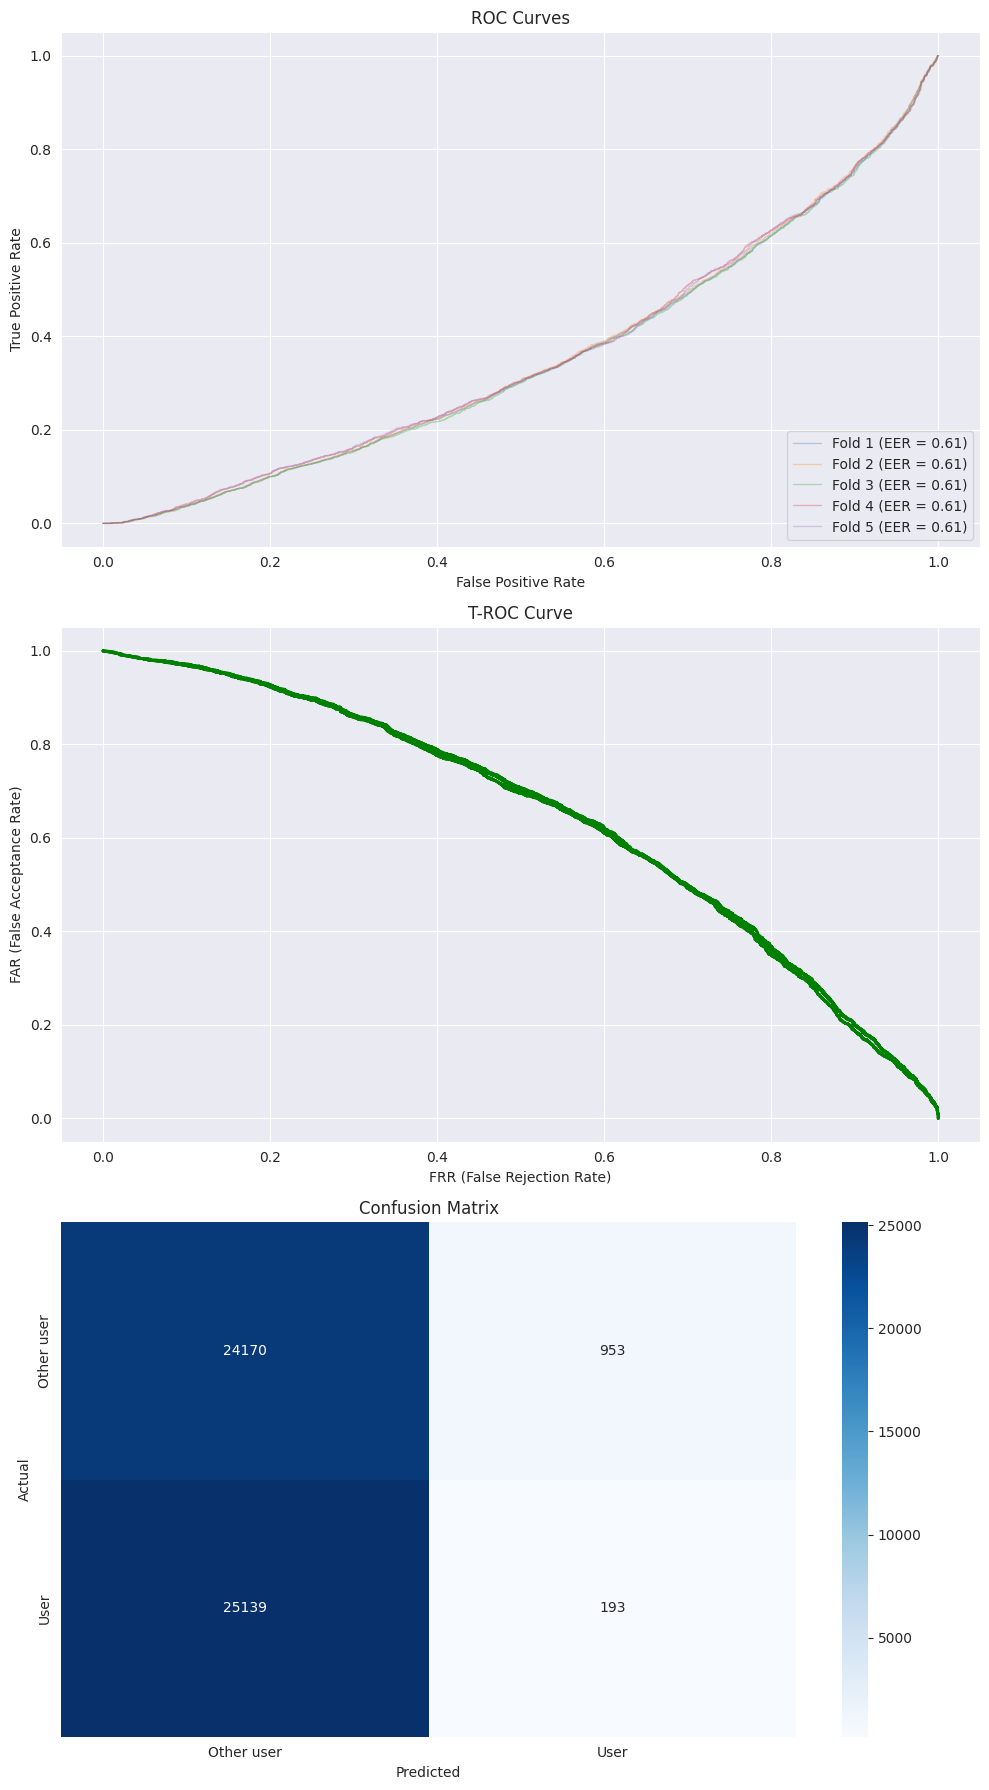

2023-09-05 01:17:51,382 — logger — INFO — X_train: (9417, 10), y_train: (9417,)
Reading training dataset...
2023-09-05 01:17:51,388 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.021845. Found 9417 examples.
2023-09-05 01:17:51,410 — absl — INFO — Training dataset read in 0:00:00.021845. Found 9417 examples.
Training model...
2023-09-05 01:17:51,411 — absl — INFO — Training model...


[INFO 23-09-05 01:17:51.4705 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.458772
2023-09-05 01:17:51,869 — absl — INFO — Model trained in 0:00:00.458772
Compiling model...
2023-09-05 01:17:51,877 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:51.7951 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:51.8650 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:51.8650 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:52,028 — absl — INFO — Model compiled.
214/214 - 1s - 527ms/epoch - 2ms/step
2023-09-05 01:17:52,677 — logger — INFO — X_train: (9417, 10), y_train: (9417,)
Reading training dataset...
2023-09-05 01:17:52,683 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.019339. Found 9417 examples.
2023-09-05 01:17:52,702 — absl — INFO — Training dataset read in 0:00:00.019339. Found 9417 examples.
Training model...
2023-09-05 01:17:52,703 — absl — INFO — Training model...


[INFO 23-09-05 01:17:52.7576 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.369757
2023-09-05 01:17:53,072 — absl — INFO — Model trained in 0:00:00.369757
Compiling model...
2023-09-05 01:17:53,077 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:53,187 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:53.0261 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:53.0692 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:53.0693 CEST kernel.cc:1075] Use fast generic engine


161/161 - 0s - 303ms/epoch - 2ms/step
2023-09-05 01:17:53,580 — logger — INFO — X_train: (9418, 10), y_train: (9418,)
Reading training dataset...
2023-09-05 01:17:53,585 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.018006. Found 9418 examples.
2023-09-05 01:17:53,604 — absl — INFO — Training dataset read in 0:00:00.018006. Found 9418 examples.
Training model...
2023-09-05 01:17:53,605 — absl — INFO — Training model...


[INFO 23-09-05 01:17:53.6653 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.386180
2023-09-05 01:17:53,991 — absl — INFO — Model trained in 0:00:00.386180
Compiling model...
2023-09-05 01:17:53,997 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:54,107 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:53.9414 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:53.9875 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:53.9875 CEST kernel.cc:1075] Use fast generic engine


121/121 - 0s - 233ms/epoch - 2ms/step
2023-09-05 01:17:54,415 — logger — INFO — X_train: (9418, 10), y_train: (9418,)
Reading training dataset...
2023-09-05 01:17:54,420 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.017226. Found 9418 examples.
2023-09-05 01:17:54,437 — absl — INFO — Training dataset read in 0:00:00.017226. Found 9418 examples.
Training model...
2023-09-05 01:17:54,438 — absl — INFO — Training model...


[INFO 23-09-05 01:17:54.4882 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.360489
2023-09-05 01:17:54,799 — absl — INFO — Model trained in 0:00:00.360489
Compiling model...
2023-09-05 01:17:54,804 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:54,919 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:54.7511 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:54.7953 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:54.7953 CEST kernel.cc:1075] Use fast generic engine


91/91 - 0s - 189ms/epoch - 2ms/step
2023-09-05 01:17:55,174 — logger — INFO — X_train: (9418, 10), y_train: (9418,)
Reading training dataset...
2023-09-05 01:17:55,181 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.017647. Found 9418 examples.
2023-09-05 01:17:55,198 — absl — INFO — Training dataset read in 0:00:00.017647. Found 9418 examples.
Training model...
2023-09-05 01:17:55,199 — absl — INFO — Training model...


[INFO 23-09-05 01:17:55.2509 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.390239
2023-09-05 01:17:55,590 — absl — INFO — Model trained in 0:00:00.390239
Compiling model...
2023-09-05 01:17:55,596 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:55,711 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:55.5404 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:55.5855 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:55.5856 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-05 01:17:55.5856 CEST kernel.cc:1075] Use fast generic engine


68/68 - 0s - 170ms/epoch - 2ms/step


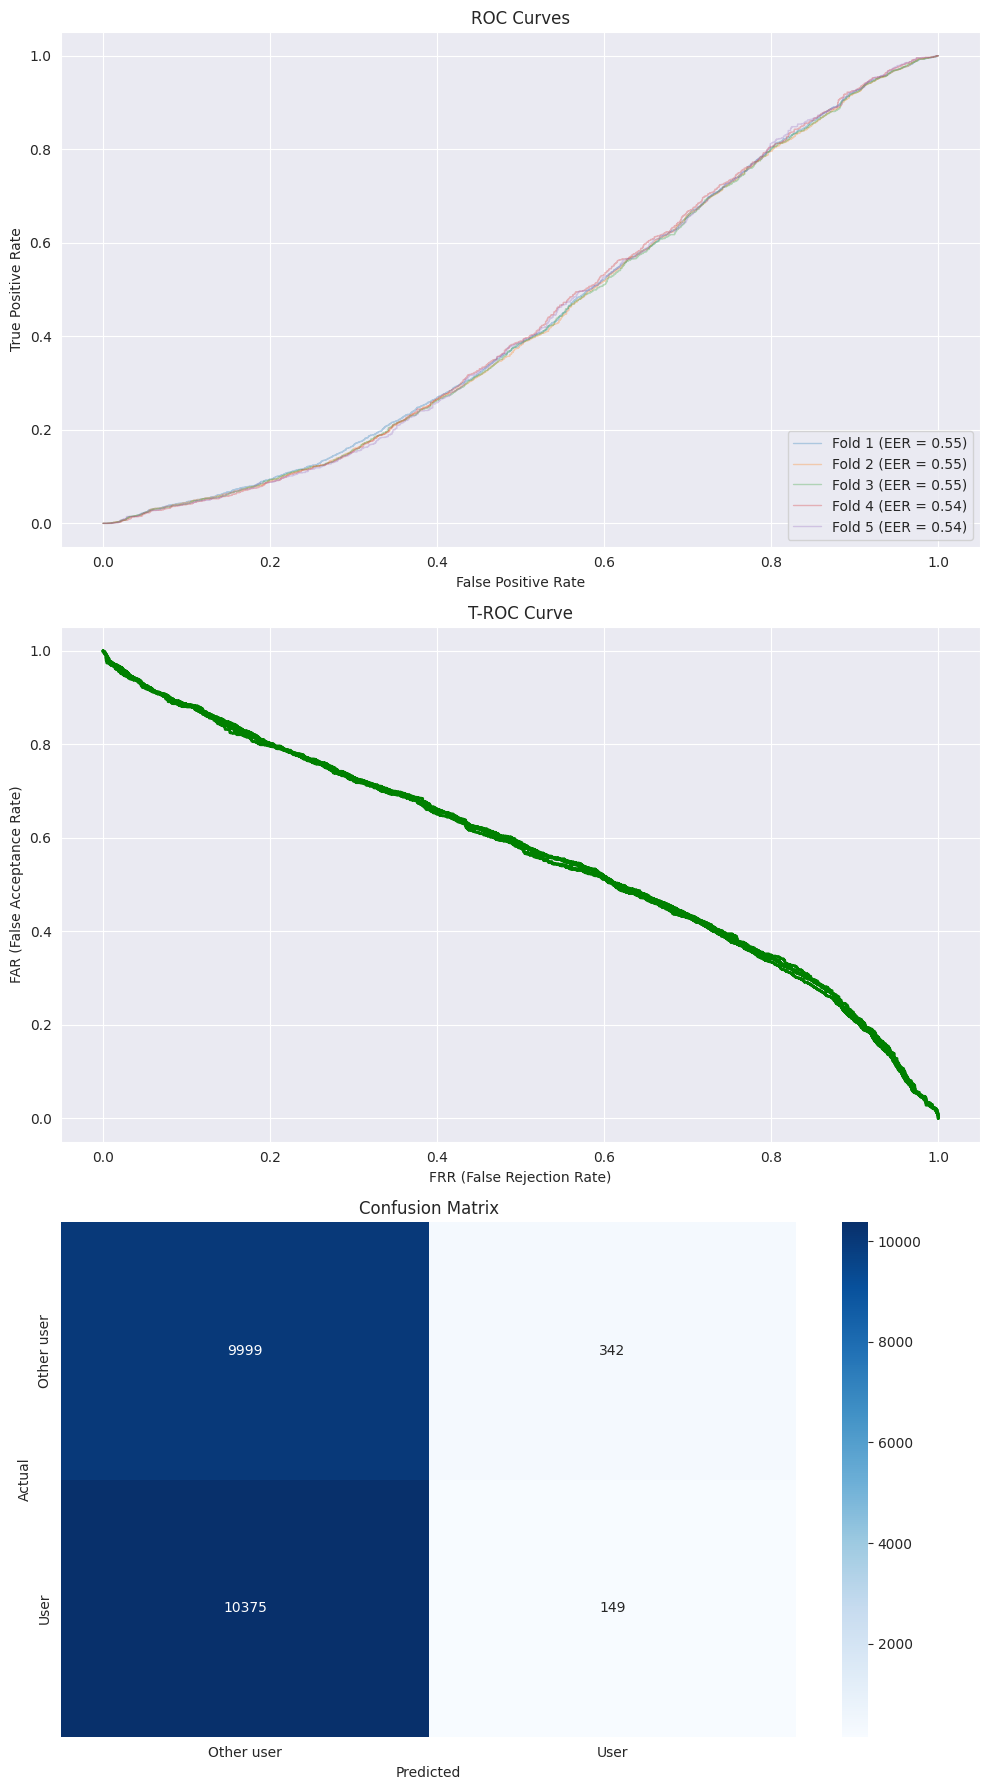

2023-09-05 01:17:56,812 — logger — INFO — X_train: (480, 10), y_train: (480,)
Reading training dataset...
2023-09-05 01:17:56,817 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006837. Found 480 examples.
2023-09-05 01:17:56,824 — absl — INFO — Training dataset read in 0:00:00.006837. Found 480 examples.
Training model...
2023-09-05 01:17:56,825 — absl — INFO — Training model...
Model trained in 0:00:00.128767
2023-09-05 01:17:56,954 — absl — INFO — Model trained in 0:00:00.128767
Compiling model...
2023-09-05 01:17:56,958 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:57,045 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:56.8720 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:56.9059 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:56.9500 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:56.9501 CEST kernel.cc:1075] Use fast generic engine


16/16 - 0s - 74ms/epoch - 5ms/step
2023-09-05 01:17:57,167 — logger — INFO — X_train: (480, 10), y_train: (480,)
Reading training dataset...
2023-09-05 01:17:57,174 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.010735. Found 480 examples.
2023-09-05 01:17:57,185 — absl — INFO — Training dataset read in 0:00:00.010735. Found 480 examples.
Training model...
2023-09-05 01:17:57,186 — absl — INFO — Training model...
Model trained in 0:00:00.139563
2023-09-05 01:17:57,325 — absl — INFO — Model trained in 0:00:00.139563
Compiling model...
2023-09-05 01:17:57,330 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:57,430 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:57.2415 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:57.2769 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:57.3217 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:57.3217 CEST kernel.cc:1075] Use fast generic engine


12/12 - 0s - 65ms/epoch - 5ms/step
2023-09-05 01:17:57,538 — logger — INFO — X_train: (480, 10), y_train: (480,)
Reading training dataset...
2023-09-05 01:17:57,543 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006551. Found 480 examples.
2023-09-05 01:17:57,550 — absl — INFO — Training dataset read in 0:00:00.006551. Found 480 examples.
Training model...
2023-09-05 01:17:57,551 — absl — INFO — Training model...
Model trained in 0:00:00.150673
2023-09-05 01:17:57,701 — absl — INFO — Model trained in 0:00:00.150673
Compiling model...
2023-09-05 01:17:57,707 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:57,802 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:57.6115 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:57.6498 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:57.6962 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:57.6962 CEST kernel.cc:1075] Use fast generic engine


9/9 - 0s - 59ms/epoch - 7ms/step
2023-09-05 01:17:57,904 — logger — INFO — X_train: (480, 10), y_train: (480,)
Reading training dataset...
2023-09-05 01:17:57,911 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007351. Found 480 examples.
2023-09-05 01:17:57,919 — absl — INFO — Training dataset read in 0:00:00.007351. Found 480 examples.
Training model...
2023-09-05 01:17:57,919 — absl — INFO — Training model...
Model trained in 0:00:00.142823
2023-09-05 01:17:58,062 — absl — INFO — Model trained in 0:00:00.142823
Compiling model...
2023-09-05 01:17:58,067 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:58,166 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:57.9704 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:58.0077 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:58.0583 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:58.0583 CEST kernel.cc:1075] Use fast generic engine


7/7 - 0s - 60ms/epoch - 9ms/step
2023-09-05 01:17:58,269 — logger — INFO — X_train: (480, 10), y_train: (480,)
Reading training dataset...
2023-09-05 01:17:58,274 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008681. Found 480 examples.
2023-09-05 01:17:58,283 — absl — INFO — Training dataset read in 0:00:00.008681. Found 480 examples.
Training model...
2023-09-05 01:17:58,283 — absl — INFO — Training model...
Model trained in 0:00:00.167887
2023-09-05 01:17:58,451 — absl — INFO — Model trained in 0:00:00.167887
Compiling model...
2023-09-05 01:17:58,455 — absl — INFO — Compiling model...


[INFO 23-09-05 01:17:58.3324 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:58.3695 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:58.4477 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:58.4477 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:17:58,548 — absl — INFO — Model compiled.
5/5 - 0s - 51ms/epoch - 10ms/step


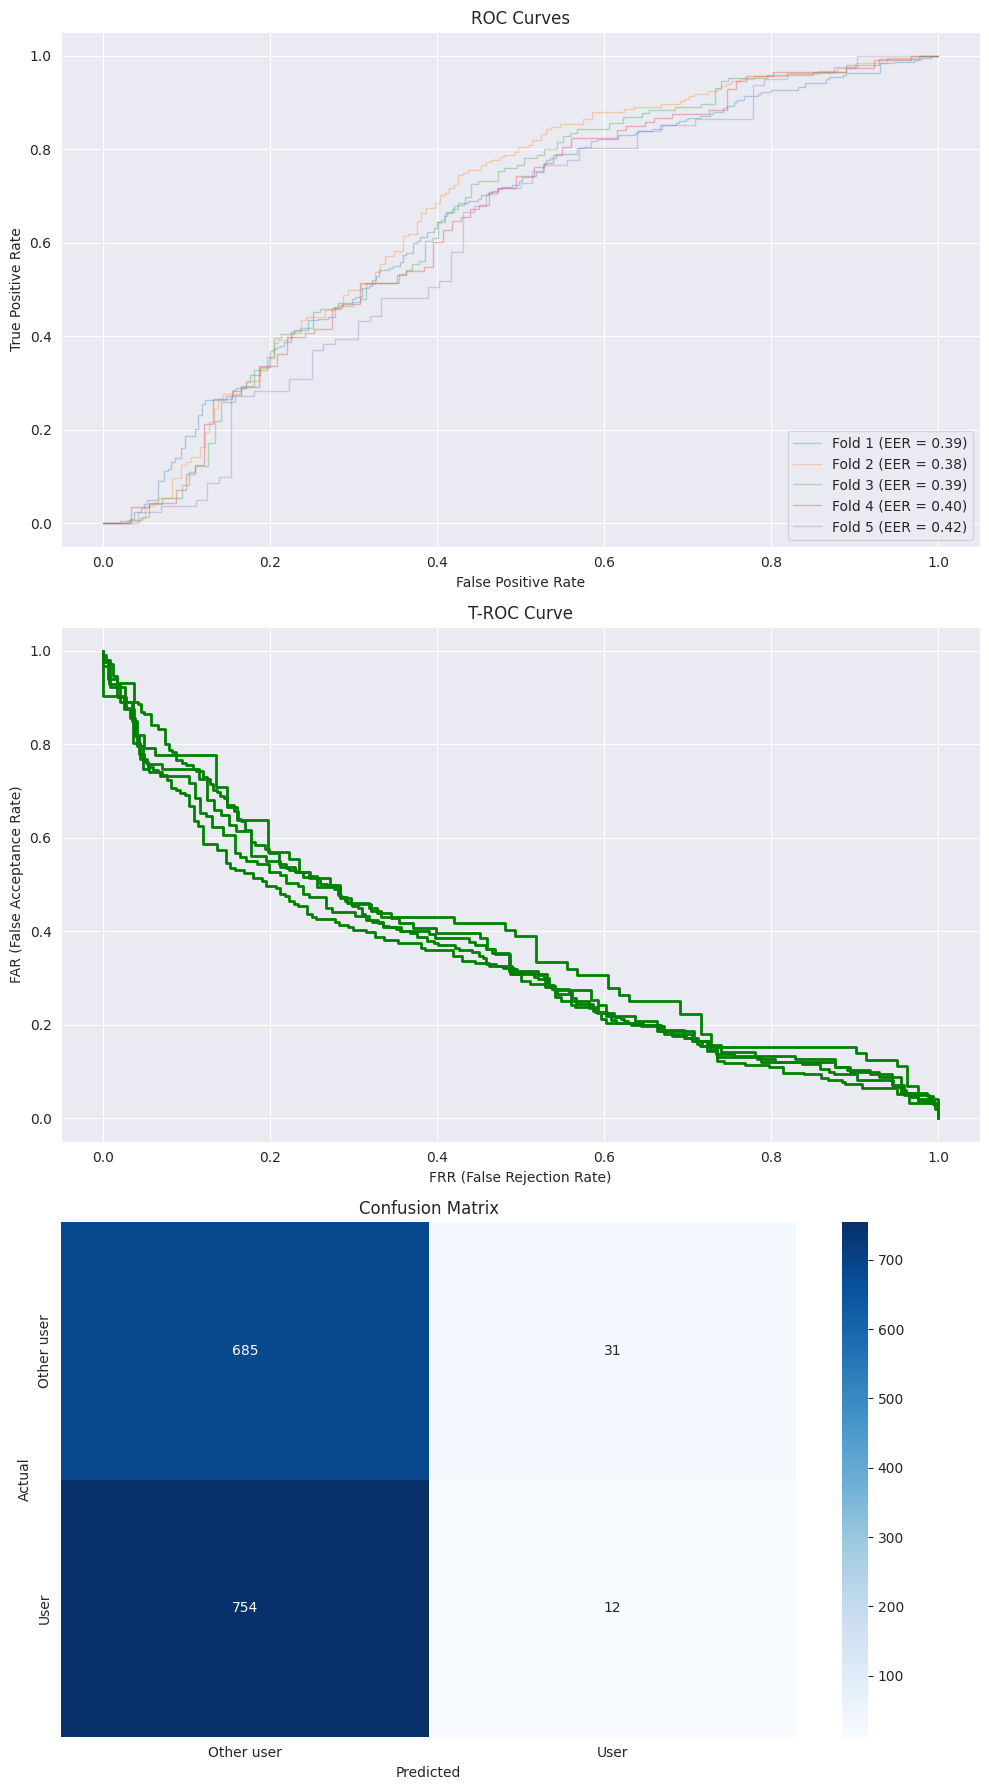

2023-09-05 01:17:59,467 — logger — INFO — X_train: (649, 10), y_train: (649,)
Reading training dataset...
2023-09-05 01:17:59,473 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007882. Found 649 examples.
2023-09-05 01:17:59,481 — absl — INFO — Training dataset read in 0:00:00.007882. Found 649 examples.
Training model...
2023-09-05 01:17:59,482 — absl — INFO — Training model...
Model trained in 0:00:00.130144
2023-09-05 01:17:59,612 — absl — INFO — Model trained in 0:00:00.130144
Compiling model...
2023-09-05 01:17:59,616 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:17:59,706 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:59.5267 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:59.5627 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:17:59.6084 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:17:59.6084 CEST kernel.cc:1075] Use fast generic engine


22/22 - 0s - 111ms/epoch - 5ms/step
2023-09-05 01:17:59,878 — logger — INFO — X_train: (649, 10), y_train: (649,)
Reading training dataset...
2023-09-05 01:17:59,884 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.009868. Found 649 examples.
2023-09-05 01:17:59,895 — absl — INFO — Training dataset read in 0:00:00.009868. Found 649 examples.
Training model...
2023-09-05 01:17:59,897 — absl — INFO — Training model...
Model trained in 0:00:00.151538
2023-09-05 01:18:00,049 — absl — INFO — Model trained in 0:00:00.151538
Compiling model...
2023-09-05 01:18:00,053 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:00,147 — absl — INFO — Model compiled.


[INFO 23-09-05 01:17:59.9608 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:00.0007 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:00.0449 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:00.0450 CEST kernel.cc:1075] Use fast generic engine


17/17 - 0s - 74ms/epoch - 4ms/step
2023-09-05 01:18:00,270 — logger — INFO — X_train: (650, 10), y_train: (650,)
Reading training dataset...
2023-09-05 01:18:00,275 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007165. Found 650 examples.
2023-09-05 01:18:00,282 — absl — INFO — Training dataset read in 0:00:00.007165. Found 650 examples.
Training model...
2023-09-05 01:18:00,282 — absl — INFO — Training model...
Model trained in 0:00:00.163581
2023-09-05 01:18:00,446 — absl — INFO — Model trained in 0:00:00.163581
Compiling model...
2023-09-05 01:18:00,450 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:00.3330 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:00.3887 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:00.4428 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:00.4428 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:00,550 — absl — INFO — Model compiled.
13/13 - 0s - 68ms/epoch - 5ms/step
2023-09-05 01:18:00,671 — logger — INFO — X_train: (650, 10), y_train: (650,)
Reading training dataset...
2023-09-05 01:18:00,676 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006354. Found 650 examples.
2023-09-05 01:18:00,682 — absl — INFO — Training dataset read in 0:00:00.006354. Found 650 examples.
Training model...
2023-09-05 01:18:00,683 — absl — INFO — Training model...
Model trained in 0:00:00.133877
2023-09-05 01:18:00,817 — absl — INFO — Model trained in 0:00:00.133877
Compiling model...
2023-09-05 01:18:00,821 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:00,931 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:00.7336 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:00.7692 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:00.8133 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:00.8134 CEST kernel.cc:1075] Use fast generic engine


10/10 - 0s - 62ms/epoch - 6ms/step
2023-09-05 01:18:01,040 — logger — INFO — X_train: (650, 10), y_train: (650,)
Reading training dataset...
2023-09-05 01:18:01,045 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006374. Found 650 examples.
2023-09-05 01:18:01,051 — absl — INFO — Training dataset read in 0:00:00.006374. Found 650 examples.
Training model...
2023-09-05 01:18:01,052 — absl — INFO — Training model...
Model trained in 0:00:00.132470
2023-09-05 01:18:01,185 — absl — INFO — Model trained in 0:00:00.132470
Compiling model...
2023-09-05 01:18:01,190 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:01,281 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:01.1015 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:01.1380 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:01.1811 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:01.1811 CEST kernel.cc:1075] Use fast generic engine


7/7 - 0s - 57ms/epoch - 8ms/step


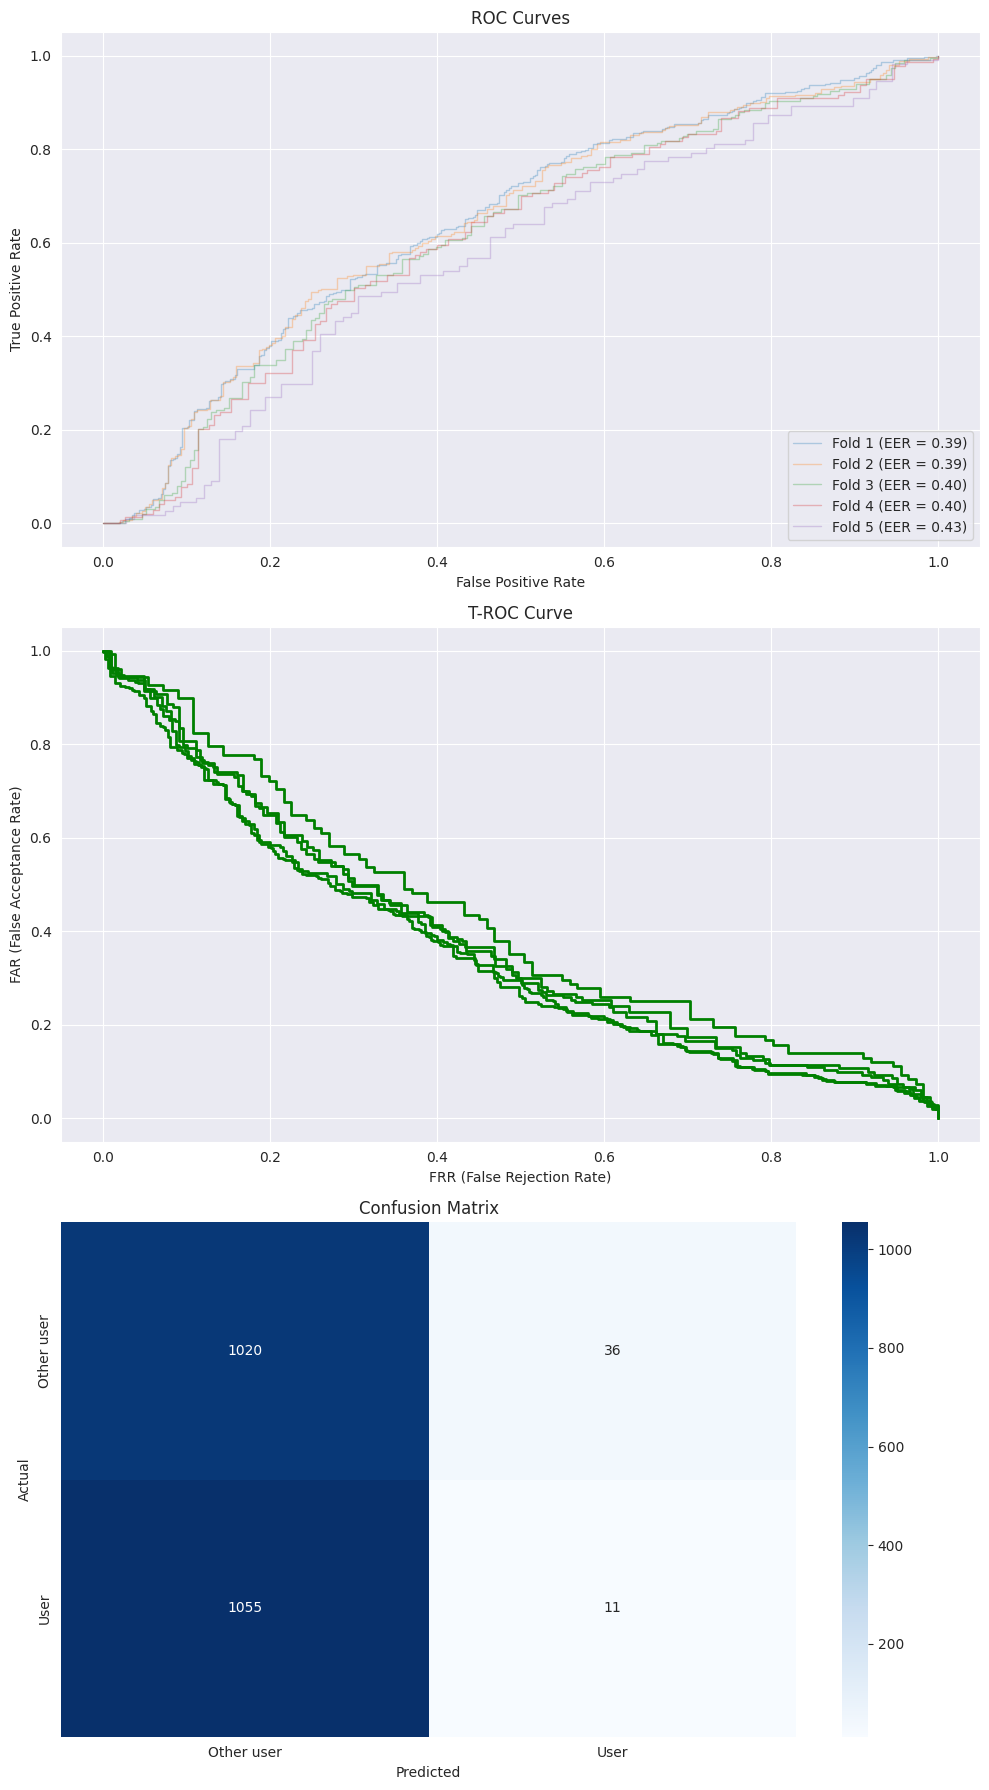

2023-09-05 01:18:02,207 — logger — INFO — X_train: (4929, 10), y_train: (4929,)
Reading training dataset...
2023-09-05 01:18:02,213 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.014705. Found 4929 examples.
2023-09-05 01:18:02,228 — absl — INFO — Training dataset read in 0:00:00.014705. Found 4929 examples.
Training model...
2023-09-05 01:18:02,229 — absl — INFO — Training model...
Model trained in 0:00:00.238597
2023-09-05 01:18:02,467 — absl — INFO — Model trained in 0:00:00.238597
Compiling model...
2023-09-05 01:18:02,468 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:02.2729 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:02.4166 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:02.4594 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:02.4595 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:02,575 — absl — INFO — Model compiled.
176/176 - 0s - 345ms/epoch - 2ms/step
2023-09-05 01:18:03,015 — logger — INFO — X_train: (4929, 10), y_train: (4929,)
Reading training dataset...
2023-09-05 01:18:03,020 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.011632. Found 4929 examples.
2023-09-05 01:18:03,032 — absl — INFO — Training dataset read in 0:00:00.011632. Found 4929 examples.
Training model...
2023-09-05 01:18:03,033 — absl — INFO — Training model...


[INFO 23-09-05 01:18:03.0827 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:03.2381 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:03.2812 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:03.2812 CEST kernel.cc:1075] Use fast generic engine


Model trained in 0:00:00.251820
2023-09-05 01:18:03,285 — absl — INFO — Model trained in 0:00:00.251820
Compiling model...
2023-09-05 01:18:03,289 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:03,388 — absl — INFO — Model compiled.
132/132 - 0s - 250ms/epoch - 2ms/step
2023-09-05 01:18:03,725 — logger — INFO — X_train: (4930, 10), y_train: (4930,)
Reading training dataset...
2023-09-05 01:18:03,732 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.015383. Found 4930 examples.
2023-09-05 01:18:03,748 — absl — INFO — Training dataset read in 0:00:00.015383. Found 4930 examples.
Training model...
2023-09-05 01:18:03,748 — absl — INFO — Training model...
Model trained in 0:00:00.248089


[INFO 23-09-05 01:18:03.7962 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:03.9474 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:03.9933 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:03.9933 CEST kernel.cc:1075] Use fast generic engine


2023-09-05 01:18:03,997 — absl — INFO — Model trained in 0:00:00.248089
Compiling model...
2023-09-05 01:18:04,001 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:04,113 — absl — INFO — Model compiled.
99/99 - 0s - 188ms/epoch - 2ms/step
2023-09-05 01:18:04,369 — logger — INFO — X_train: (4930, 10), y_train: (4930,)
Reading training dataset...
2023-09-05 01:18:04,374 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.014359. Found 4930 examples.
2023-09-05 01:18:04,388 — absl — INFO — Training dataset read in 0:00:00.014359. Found 4930 examples.
Training model...
2023-09-05 01:18:04,389 — absl — INFO — Training model...
Model trained in 0:00:00.248389
2023-09-05 01:18:04,638 — absl — INFO — Model trained in 0:00:00.248389


[INFO 23-09-05 01:18:04.4398 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:04.5937 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:04.6347 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:04.6347 CEST kernel.cc:1075] Use fast generic engine


Compiling model...
2023-09-05 01:18:04,643 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:04,753 — absl — INFO — Model compiled.
74/74 - 0s - 170ms/epoch - 2ms/step
2023-09-05 01:18:04,983 — logger — INFO — X_train: (4930, 10), y_train: (4930,)
Reading training dataset...
2023-09-05 01:18:04,989 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.013970. Found 4930 examples.
2023-09-05 01:18:05,003 — absl — INFO — Training dataset read in 0:00:00.013970. Found 4930 examples.
Training model...
2023-09-05 01:18:05,004 — absl — INFO — Training model...
Model trained in 0:00:00.258818


[INFO 23-09-05 01:18:05.0622 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:05.2164 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:05.2594 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:05.2595 CEST kernel.cc:1075] Use fast generic engine


2023-09-05 01:18:05,263 — absl — INFO — Model trained in 0:00:00.258818
Compiling model...
2023-09-05 01:18:05,267 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:05,372 — absl — INFO — Model compiled.
56/56 - 0s - 157ms/epoch - 3ms/step


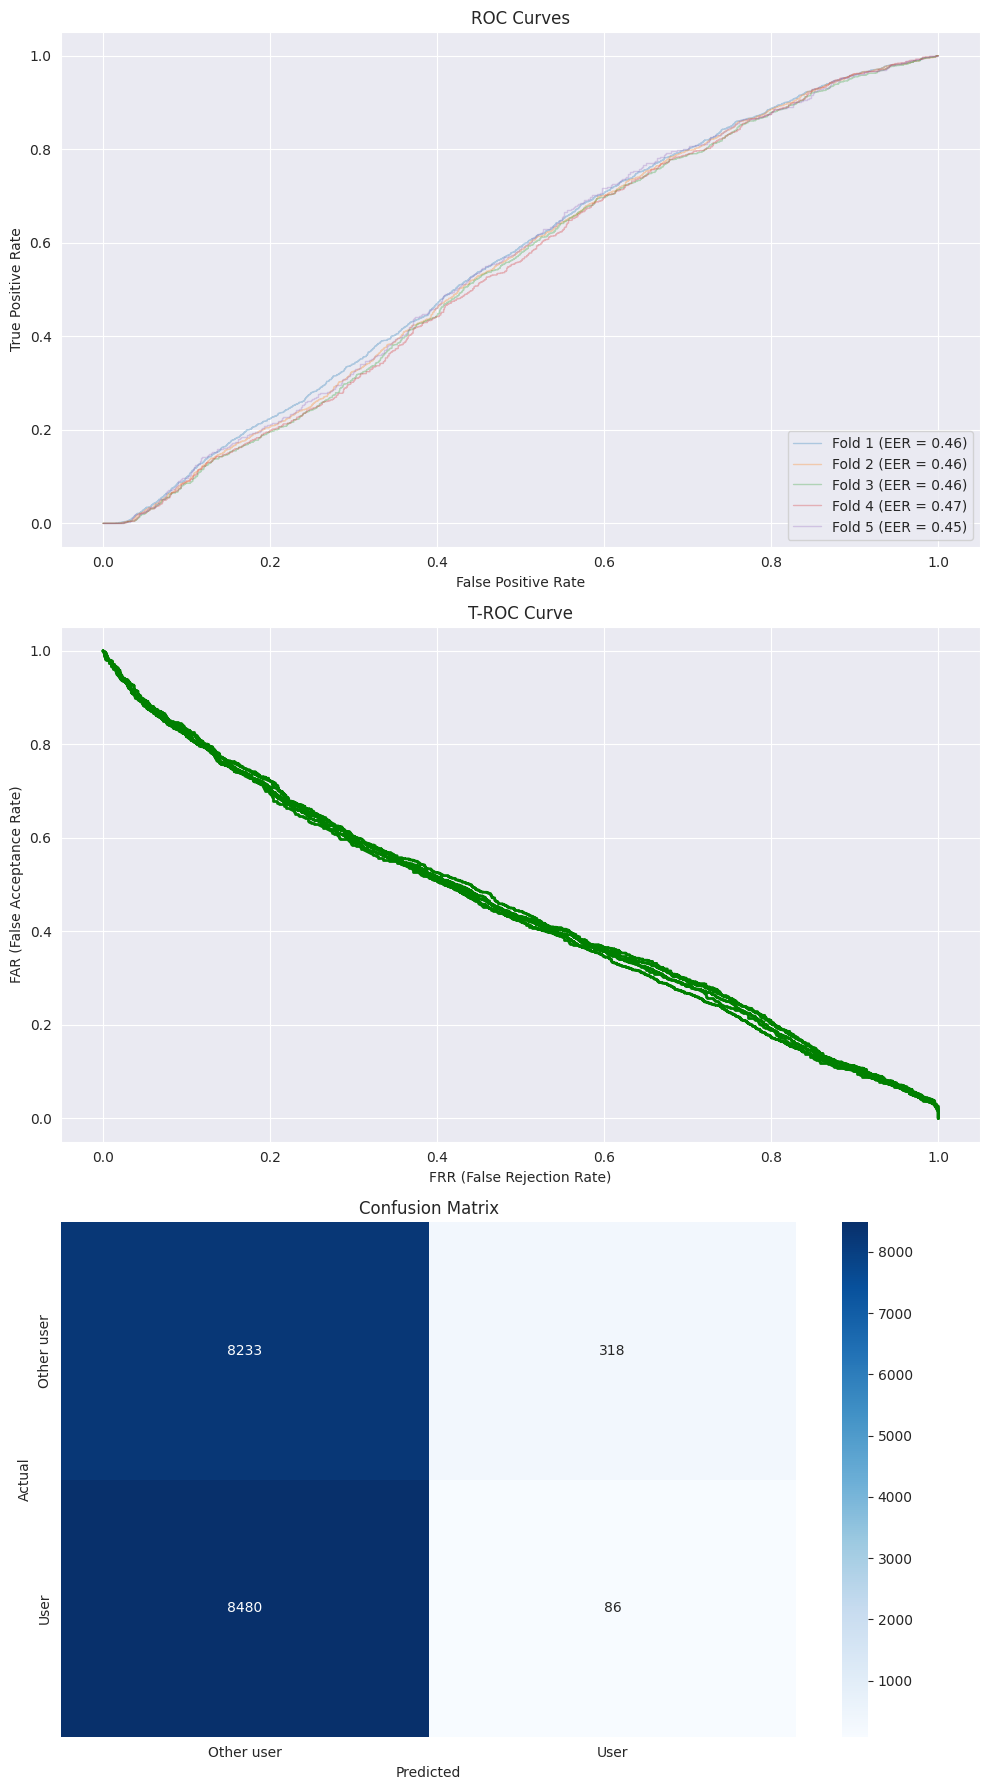

2023-09-05 01:18:06,438 — logger — INFO — X_train: (1065, 10), y_train: (1065,)
Reading training dataset...
2023-09-05 01:18:06,444 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008211. Found 1065 examples.
2023-09-05 01:18:06,453 — absl — INFO — Training dataset read in 0:00:00.008211. Found 1065 examples.
Training model...
2023-09-05 01:18:06,453 — absl — INFO — Training model...
Model trained in 0:00:00.159393
2023-09-05 01:18:06,613 — absl — INFO — Model trained in 0:00:00.159393
Compiling model...
2023-09-05 01:18:06,617 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:06.5022 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:06.5596 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:06.6088 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:06.6088 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-05 01:18:06.6088 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:06,722 — absl — INFO — Model compiled.
39/39 - 0s - 123ms/epoch - 3ms/step
2023-09-05 01:18:06,902 — logger — INFO — X_train: (1065, 10), y_train: (1065,)
Reading training dataset...
2023-09-05 01:18:06,907 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.019088. Found 1065 examples.
2023-09-05 01:18:06,926 — absl — INFO — Training dataset read in 0:00:00.019088. Found 1065 examples.
Training model...
2023-09-05 01:18:06,932 — absl — INFO — Training model...
Model trained in 0:00:00.186948
2023-09-05 01:18:07,117 — absl — INFO — Model trained in 0:00:00.186948
Compiling model...
2023-09-05 01:18:07,122 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:07.0144 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:07.0659 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:07.1128 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:07.1129 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:07,221 — absl — INFO — Model compiled.
29/29 - 0s - 91ms/epoch - 3ms/step
2023-09-05 01:18:07,360 — logger — INFO — X_train: (1066, 10), y_train: (1066,)
Reading training dataset...
2023-09-05 01:18:07,365 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006765. Found 1066 examples.
2023-09-05 01:18:07,372 — absl — INFO — Training dataset read in 0:00:00.006765. Found 1066 examples.
Training model...
2023-09-05 01:18:07,373 — absl — INFO — Training model...
Model trained in 0:00:00.144322
2023-09-05 01:18:07,517 — absl — INFO — Model trained in 0:00:00.144322
Compiling model...
2023-09-05 01:18:07,522 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:07.4219 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:07.4684 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:07.5130 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:07.5130 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:07,624 — absl — INFO — Model compiled.
22/22 - 0s - 90ms/epoch - 4ms/step
2023-09-05 01:18:07,760 — logger — INFO — X_train: (1066, 10), y_train: (1066,)
Reading training dataset...
2023-09-05 01:18:07,765 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006347. Found 1066 examples.
2023-09-05 01:18:07,771 — absl — INFO — Training dataset read in 0:00:00.006347. Found 1066 examples.
Training model...
2023-09-05 01:18:07,772 — absl — INFO — Training model...
Model trained in 0:00:00.150466
2023-09-05 01:18:07,923 — absl — INFO — Model trained in 0:00:00.150466
Compiling model...
2023-09-05 01:18:07,926 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:07.8198 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:07.8704 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:07.9190 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:07.9190 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:08,032 — absl — INFO — Model compiled.
17/17 - 0s - 66ms/epoch - 4ms/step
2023-09-05 01:18:08,144 — logger — INFO — X_train: (1066, 10), y_train: (1066,)
Reading training dataset...
2023-09-05 01:18:08,150 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008173. Found 1066 examples.
2023-09-05 01:18:08,158 — absl — INFO — Training dataset read in 0:00:00.008173. Found 1066 examples.
Training model...
2023-09-05 01:18:08,159 — absl — INFO — Training model...
Model trained in 0:00:00.145083
2023-09-05 01:18:08,304 — absl — INFO — Model trained in 0:00:00.145083
Compiling model...
2023-09-05 01:18:08,308 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:08.2079 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:08.2585 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:08.3005 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:08.3006 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:08,425 — absl — INFO — Model compiled.
13/13 - 0s - 72ms/epoch - 6ms/step


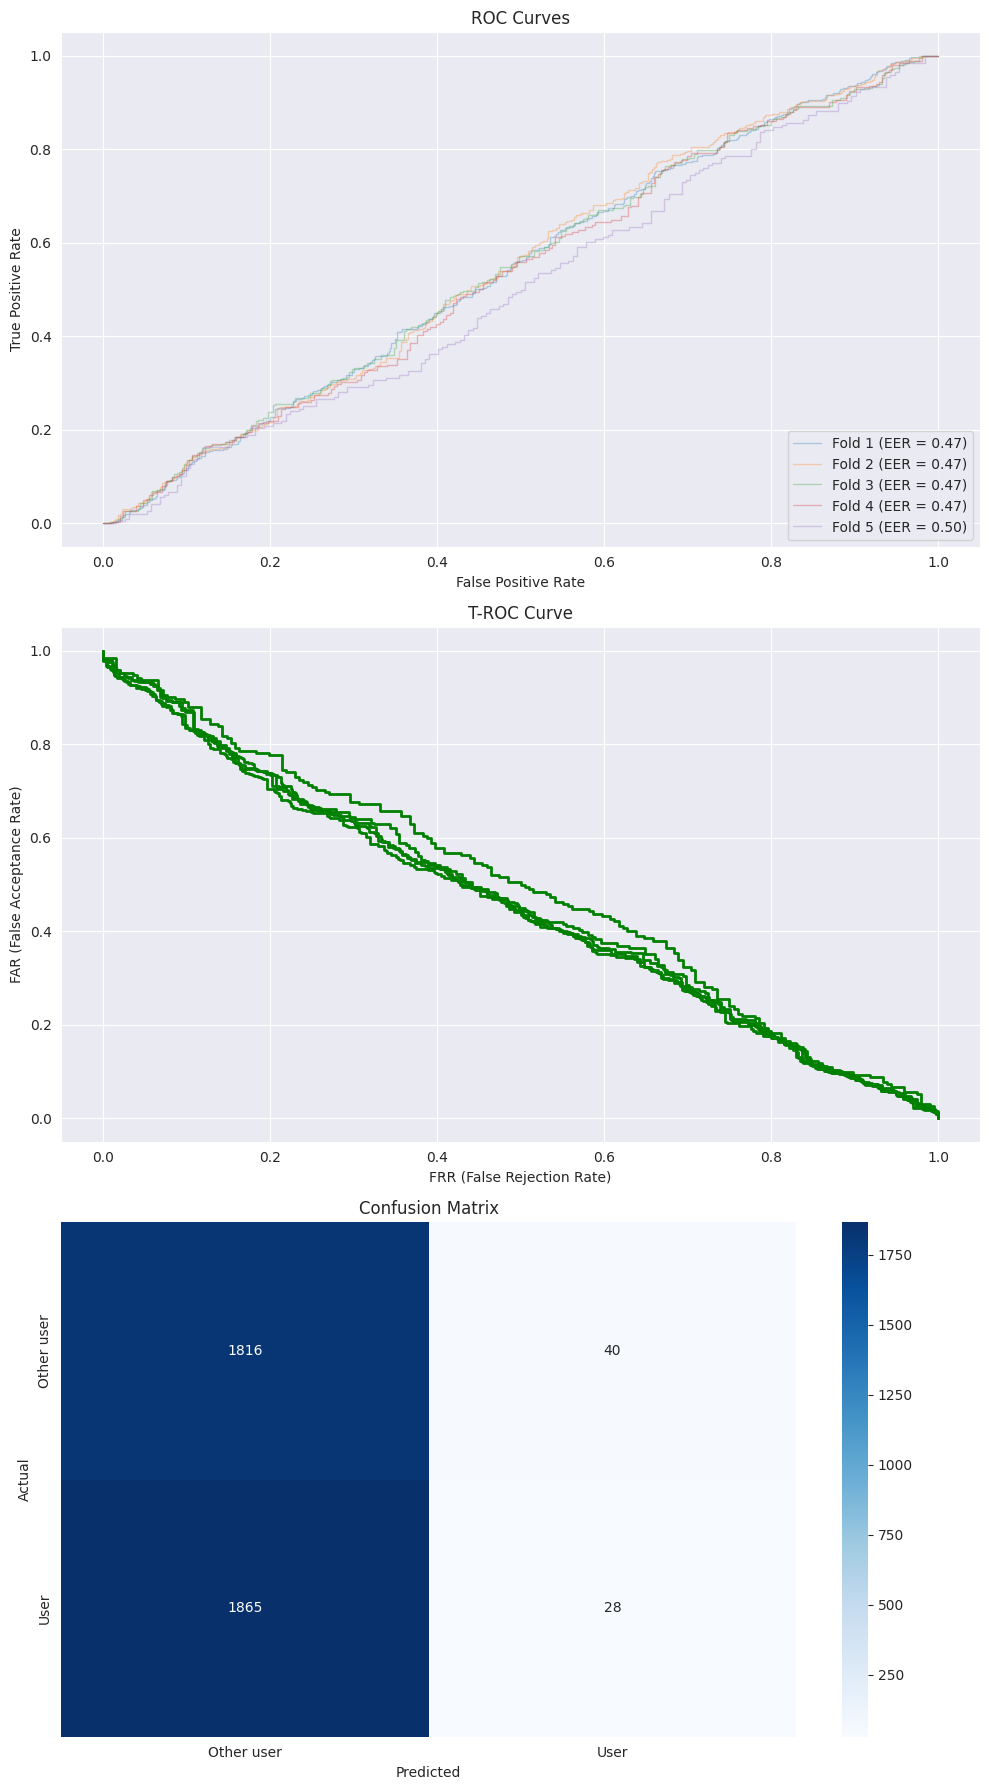

2023-09-05 01:18:09,272 — logger — INFO — X_train: (441, 10), y_train: (441,)
Reading training dataset...
2023-09-05 01:18:09,277 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006810. Found 441 examples.
2023-09-05 01:18:09,284 — absl — INFO — Training dataset read in 0:00:00.006810. Found 441 examples.
Training model...
2023-09-05 01:18:09,286 — absl — INFO — Training model...
Model trained in 0:00:00.136459
2023-09-05 01:18:09,422 — absl — INFO — Model trained in 0:00:00.136459
Compiling model...
2023-09-05 01:18:09,427 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:09,530 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:09.3361 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:09.3697 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:09.4183 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:09.4183 CEST kernel.cc:1075] Use fast generic engine


22/22 - 0s - 87ms/epoch - 4ms/step
2023-09-05 01:18:09,667 — logger — INFO — X_train: (441, 10), y_train: (441,)
Reading training dataset...
2023-09-05 01:18:09,672 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006933. Found 441 examples.
2023-09-05 01:18:09,679 — absl — INFO — Training dataset read in 0:00:00.006933. Found 441 examples.
Training model...
2023-09-05 01:18:09,679 — absl — INFO — Training model...
Model trained in 0:00:00.144644
2023-09-05 01:18:09,824 — absl — INFO — Model trained in 0:00:00.144644
Compiling model...
2023-09-05 01:18:09,829 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:09.7283 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:09.7713 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:09.8205 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:09.8205 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:09,933 — absl — INFO — Model compiled.
17/17 - 0s - 74ms/epoch - 4ms/step
2023-09-05 01:18:10,058 — logger — INFO — X_train: (442, 10), y_train: (442,)
Reading training dataset...
2023-09-05 01:18:10,063 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006452. Found 442 examples.
2023-09-05 01:18:10,070 — absl — INFO — Training dataset read in 0:00:00.006452. Found 442 examples.
Training model...
2023-09-05 01:18:10,071 — absl — INFO — Training model...
Model trained in 0:00:00.154178
2023-09-05 01:18:10,225 — absl — INFO — Model trained in 0:00:00.154178
Compiling model...
2023-09-05 01:18:10,231 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:10.1337 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:10.1694 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:10.2206 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:10.2206 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:10,336 — absl — INFO — Model compiled.
13/13 - 0s - 73ms/epoch - 6ms/step
2023-09-05 01:18:10,460 — logger — INFO — X_train: (442, 10), y_train: (442,)
Reading training dataset...
2023-09-05 01:18:10,465 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006175. Found 442 examples.
2023-09-05 01:18:10,471 — absl — INFO — Training dataset read in 0:00:00.006175. Found 442 examples.
Training model...
2023-09-05 01:18:10,472 — absl — INFO — Training model...
Model trained in 0:00:00.147342
2023-09-05 01:18:10,620 — absl — INFO — Model trained in 0:00:00.147342
Compiling model...
2023-09-05 01:18:10,624 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:10,724 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:10.5242 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:10.5573 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:10.6137 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:10.6137 CEST kernel.cc:1075] Use fast generic engine


10/10 - 0s - 76ms/epoch - 8ms/step
2023-09-05 01:18:10,852 — logger — INFO — X_train: (442, 10), y_train: (442,)
Reading training dataset...
2023-09-05 01:18:10,858 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006410. Found 442 examples.
2023-09-05 01:18:10,864 — absl — INFO — Training dataset read in 0:00:00.006410. Found 442 examples.
Training model...
2023-09-05 01:18:10,865 — absl — INFO — Training model...
Model trained in 0:00:00.160919
2023-09-05 01:18:11,026 — absl — INFO — Model trained in 0:00:00.160919
Compiling model...
2023-09-05 01:18:11,032 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:10.9118 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:10.9468 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:11.0208 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:11.0208 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:11,130 — absl — INFO — Model compiled.
7/7 - 0s - 52ms/epoch - 7ms/step


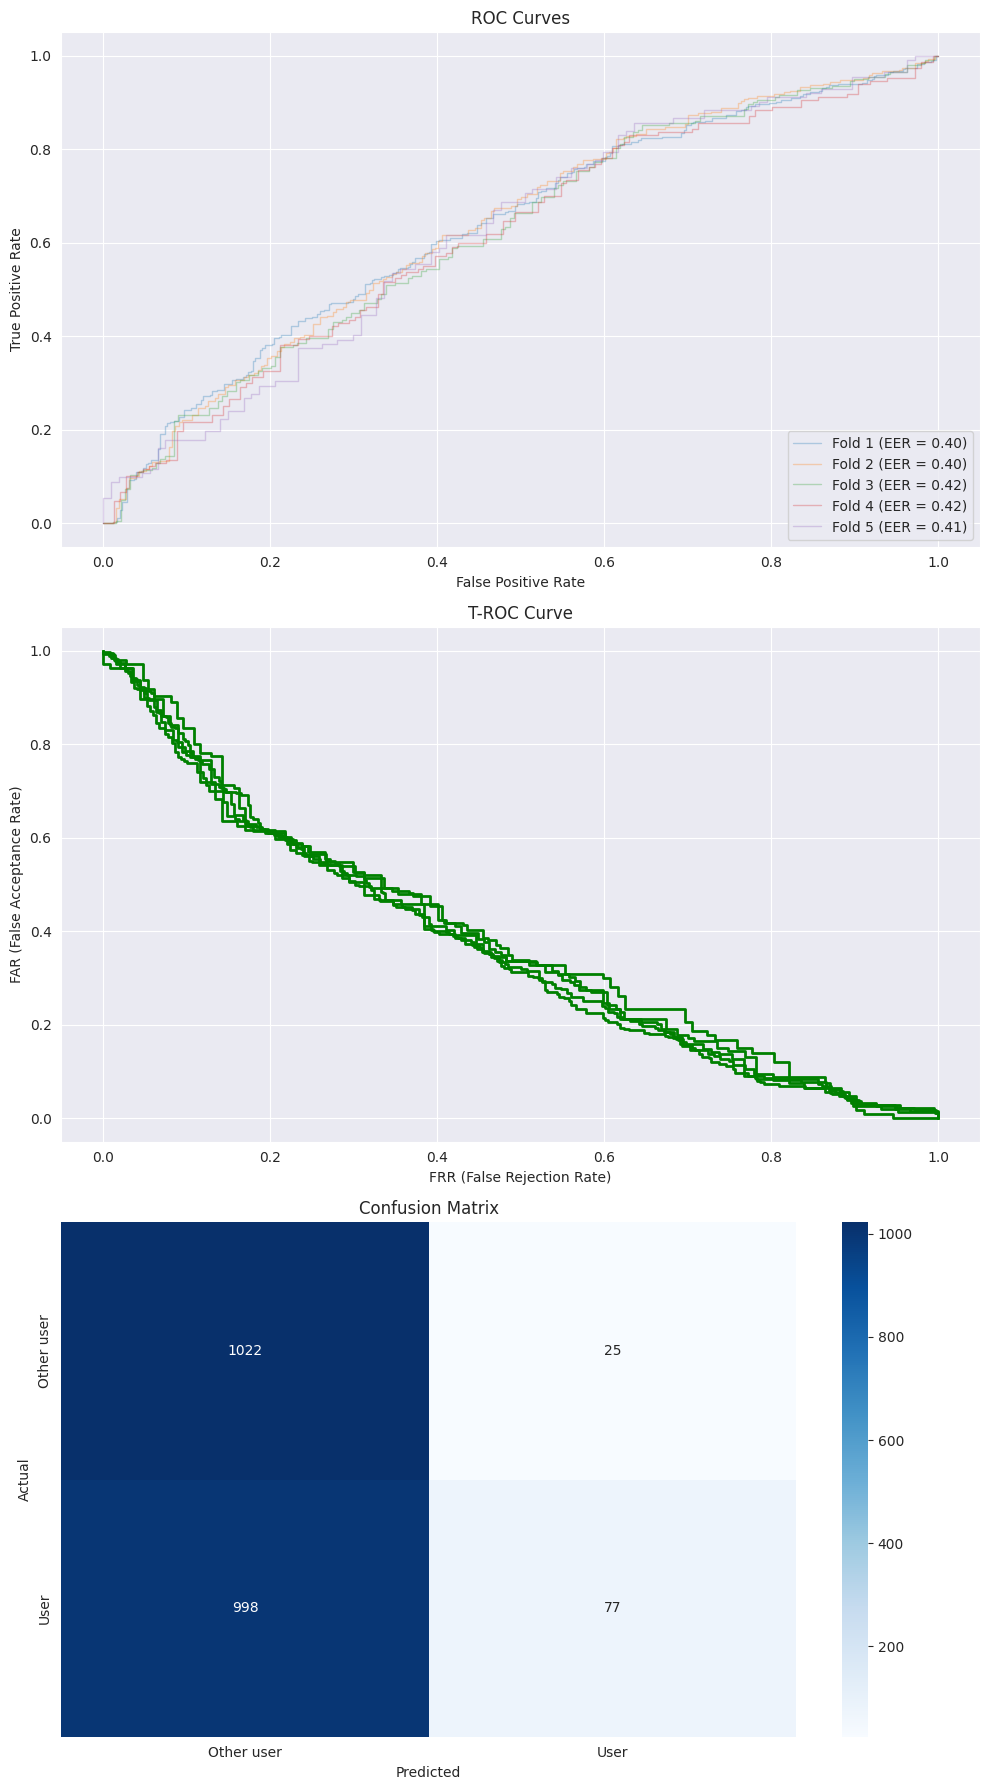

2023-09-05 01:18:12,558 — logger — INFO — X_train: (1444, 10), y_train: (1444,)
Reading training dataset...
2023-09-05 01:18:12,564 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008075. Found 1444 examples.
2023-09-05 01:18:12,572 — absl — INFO — Training dataset read in 0:00:00.008075. Found 1444 examples.
Training model...
2023-09-05 01:18:12,573 — absl — INFO — Training model...
Model trained in 0:00:00.223672
2023-09-05 01:18:12,797 — absl — INFO — Model trained in 0:00:00.223672
Compiling model...
2023-09-05 01:18:12,806 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:12.6383 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:12.7163 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:12.7872 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:12.7872 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:12,956 — absl — INFO — Model compiled.
41/41 - 0s - 205ms/epoch - 5ms/step
2023-09-05 01:18:13,243 — logger — INFO — X_train: (1445, 10), y_train: (1445,)
Reading training dataset...
2023-09-05 01:18:13,251 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.012670. Found 1445 examples.
2023-09-05 01:18:13,264 — absl — INFO — Training dataset read in 0:00:00.012670. Found 1445 examples.
Training model...
2023-09-05 01:18:13,265 — absl — INFO — Training model...
Model trained in 0:00:00.215092
2023-09-05 01:18:13,480 — absl — INFO — Model trained in 0:00:00.215092
Compiling model...
2023-09-05 01:18:13,486 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:13.3294 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:13.4052 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:13.4748 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:13.4748 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:13,623 — absl — INFO — Model compiled.
31/31 - 0s - 102ms/epoch - 3ms/step
2023-09-05 01:18:13,780 — logger — INFO — X_train: (1445, 10), y_train: (1445,)
Reading training dataset...
2023-09-05 01:18:13,786 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008533. Found 1445 examples.
2023-09-05 01:18:13,794 — absl — INFO — Training dataset read in 0:00:00.008533. Found 1445 examples.
Training model...
2023-09-05 01:18:13,795 — absl — INFO — Training model...
Model trained in 0:00:00.196039
2023-09-05 01:18:13,991 — absl — INFO — Model trained in 0:00:00.196039
Compiling model...
2023-09-05 01:18:13,999 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:13.8506 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:13.9204 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:13.9849 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:13.9850 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:14,115 — absl — INFO — Model compiled.
23/23 - 0s - 84ms/epoch - 4ms/step
2023-09-05 01:18:14,262 — logger — INFO — X_train: (1445, 10), y_train: (1445,)
Reading training dataset...
2023-09-05 01:18:14,269 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.009464. Found 1445 examples.
2023-09-05 01:18:14,278 — absl — INFO — Training dataset read in 0:00:00.009464. Found 1445 examples.
Training model...
2023-09-05 01:18:14,279 — absl — INFO — Training model...
Model trained in 0:00:00.177188
2023-09-05 01:18:14,456 — absl — INFO — Model trained in 0:00:00.177188
Compiling model...
2023-09-05 01:18:14,461 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:14.3294 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:14.4100 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:14.4525 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:14.4525 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:14,584 — absl — INFO — Model compiled.
17/17 - 0s - 69ms/epoch - 4ms/step
2023-09-05 01:18:14,706 — logger — INFO — X_train: (1445, 10), y_train: (1445,)
Reading training dataset...
2023-09-05 01:18:14,711 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007800. Found 1445 examples.
2023-09-05 01:18:14,719 — absl — INFO — Training dataset read in 0:00:00.007800. Found 1445 examples.
Training model...
2023-09-05 01:18:14,720 — absl — INFO — Training model...
Model trained in 0:00:00.161457
2023-09-05 01:18:14,882 — absl — INFO — Model trained in 0:00:00.161457
Compiling model...
2023-09-05 01:18:14,887 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:14.7713 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:14.8274 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:14.8778 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:14.8779 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:15,003 — absl — INFO — Model compiled.
13/13 - 0s - 77ms/epoch - 6ms/step


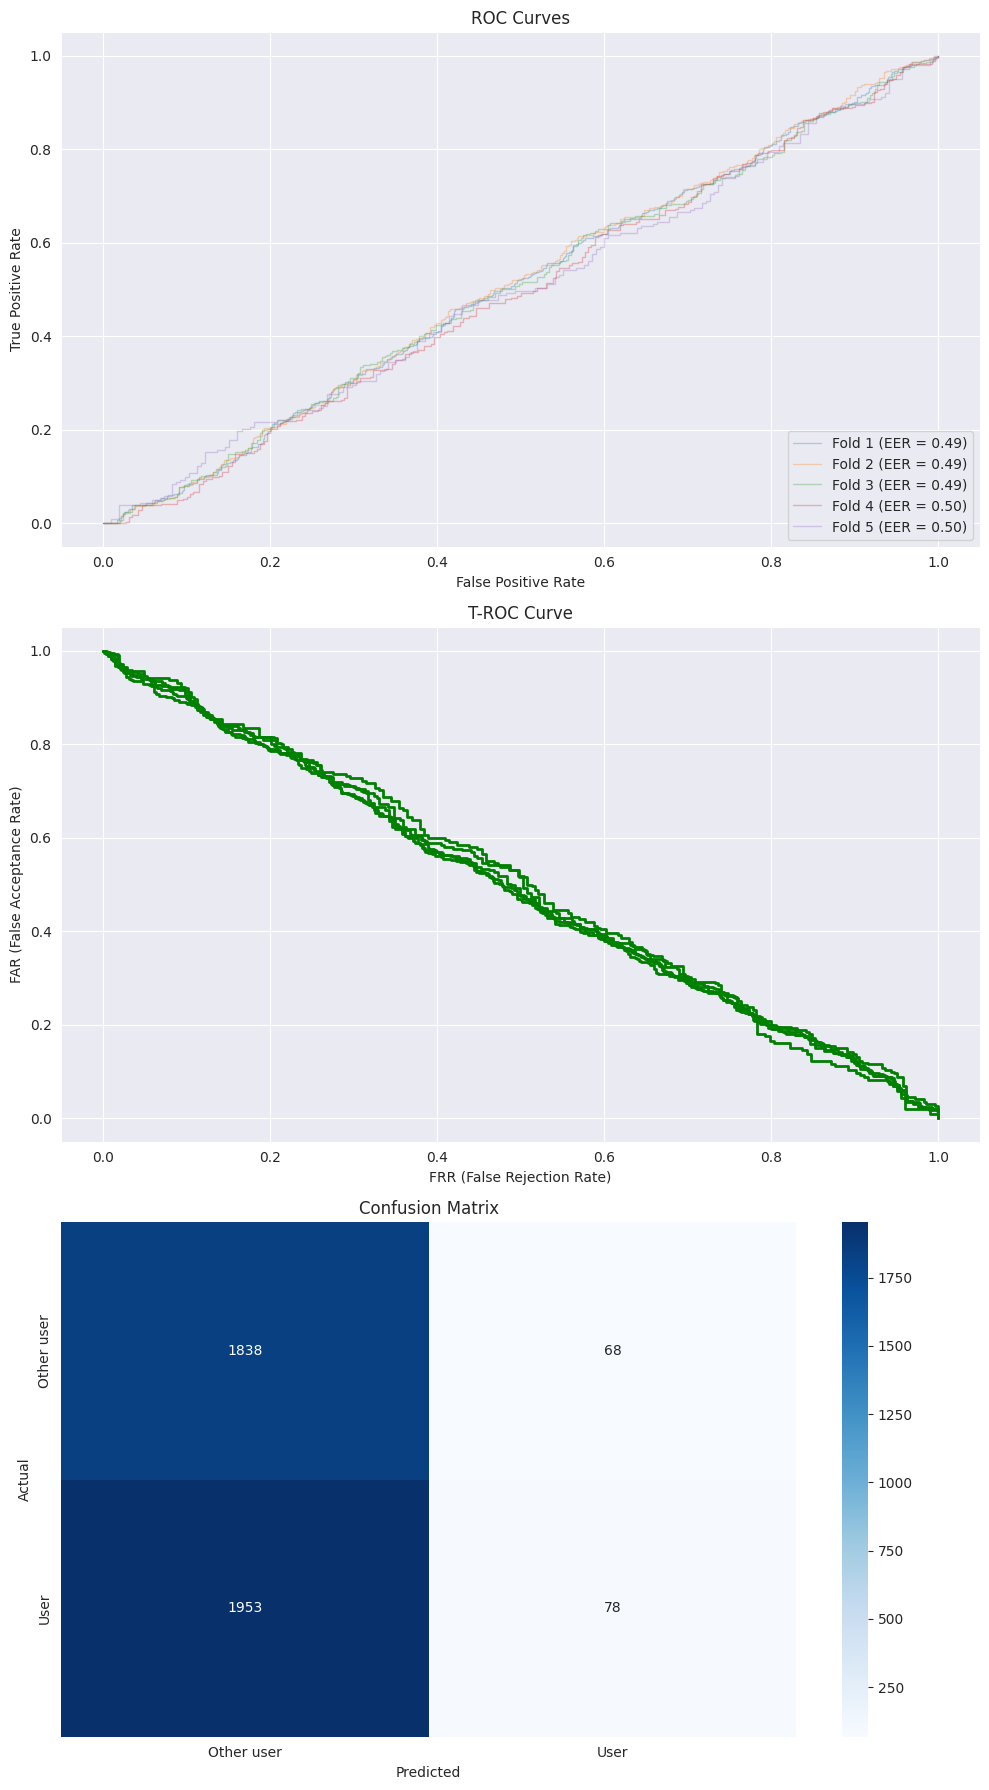

2023-09-05 01:18:15,906 — logger — INFO — X_train: (14905, 10), y_train: (14905,)
Reading training dataset...
2023-09-05 01:18:15,913 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.026311. Found 14905 examples.
2023-09-05 01:18:15,939 — absl — INFO — Training dataset read in 0:00:00.026311. Found 14905 examples.
Training model...
2023-09-05 01:18:15,940 — absl — INFO — Training model...


[INFO 23-09-05 01:18:15.9918 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.569039
2023-09-05 01:18:16,510 — absl — INFO — Model trained in 0:00:00.569039
Compiling model...
2023-09-05 01:18:16,515 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:16,630 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:16.4494 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:16.5043 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:16.5044 CEST kernel.cc:1075] Use fast generic engine


483/483 - 1s - 853ms/epoch - 2ms/step
2023-09-05 01:18:17,668 — logger — INFO — X_train: (14905, 10), y_train: (14905,)
Reading training dataset...
2023-09-05 01:18:17,675 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.028845. Found 14905 examples.
2023-09-05 01:18:17,704 — absl — INFO — Training dataset read in 0:00:00.028845. Found 14905 examples.
Training model...
2023-09-05 01:18:17,705 — absl — INFO — Training model...


[INFO 23-09-05 01:18:17.7613 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.559695
2023-09-05 01:18:18,265 — absl — INFO — Model trained in 0:00:00.559695
Compiling model...
2023-09-05 01:18:18,271 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:18,405 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:18.2179 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:18.2610 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:18.2611 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-05 01:18:18.2611 CEST kernel.cc:1075] Use fast generic engine


362/362 - 1s - 680ms/epoch - 2ms/step
2023-09-05 01:18:19,241 — logger — INFO — X_train: (14906, 10), y_train: (14906,)
Reading training dataset...
2023-09-05 01:18:19,247 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.034938. Found 14906 examples.
2023-09-05 01:18:19,282 — absl — INFO — Training dataset read in 0:00:00.034938. Found 14906 examples.
Training model...
2023-09-05 01:18:19,283 — absl — INFO — Training model...


[INFO 23-09-05 01:18:19.3445 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.560177
2023-09-05 01:18:19,843 — absl — INFO — Model trained in 0:00:00.560177
Compiling model...
2023-09-05 01:18:19,848 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:19,974 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:19.7945 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:19.8386 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:19.8387 CEST kernel.cc:1075] Use fast generic engine


272/272 - 1s - 601ms/epoch - 2ms/step
2023-09-05 01:18:20,731 — logger — INFO — X_train: (14906, 10), y_train: (14906,)
Reading training dataset...
2023-09-05 01:18:20,738 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.030433. Found 14906 examples.
2023-09-05 01:18:20,768 — absl — INFO — Training dataset read in 0:00:00.030433. Found 14906 examples.
Training model...
2023-09-05 01:18:20,770 — absl — INFO — Training model...


[INFO 23-09-05 01:18:20.8382 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.632234
2023-09-05 01:18:21,402 — absl — INFO — Model trained in 0:00:00.632234
Compiling model...
2023-09-05 01:18:21,406 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:21,518 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:21.3526 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:21.3981 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:21.3981 CEST kernel.cc:1075] Use fast generic engine


204/204 - 0s - 498ms/epoch - 2ms/step
2023-09-05 01:18:22,151 — logger — INFO — X_train: (14906, 10), y_train: (14906,)
Reading training dataset...
2023-09-05 01:18:22,157 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.037671. Found 14906 examples.
2023-09-05 01:18:22,195 — absl — INFO — Training dataset read in 0:00:00.037671. Found 14906 examples.
Training model...
2023-09-05 01:18:22,196 — absl — INFO — Training model...


[INFO 23-09-05 01:18:22.2549 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).


Model trained in 0:00:00.520605
2023-09-05 01:18:22,716 — absl — INFO — Model trained in 0:00:00.520605
Compiling model...
2023-09-05 01:18:22,720 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:22,845 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:22.6716 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:22.7130 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:22.7130 CEST kernel.cc:1075] Use fast generic engine


153/153 - 0s - 408ms/epoch - 3ms/step


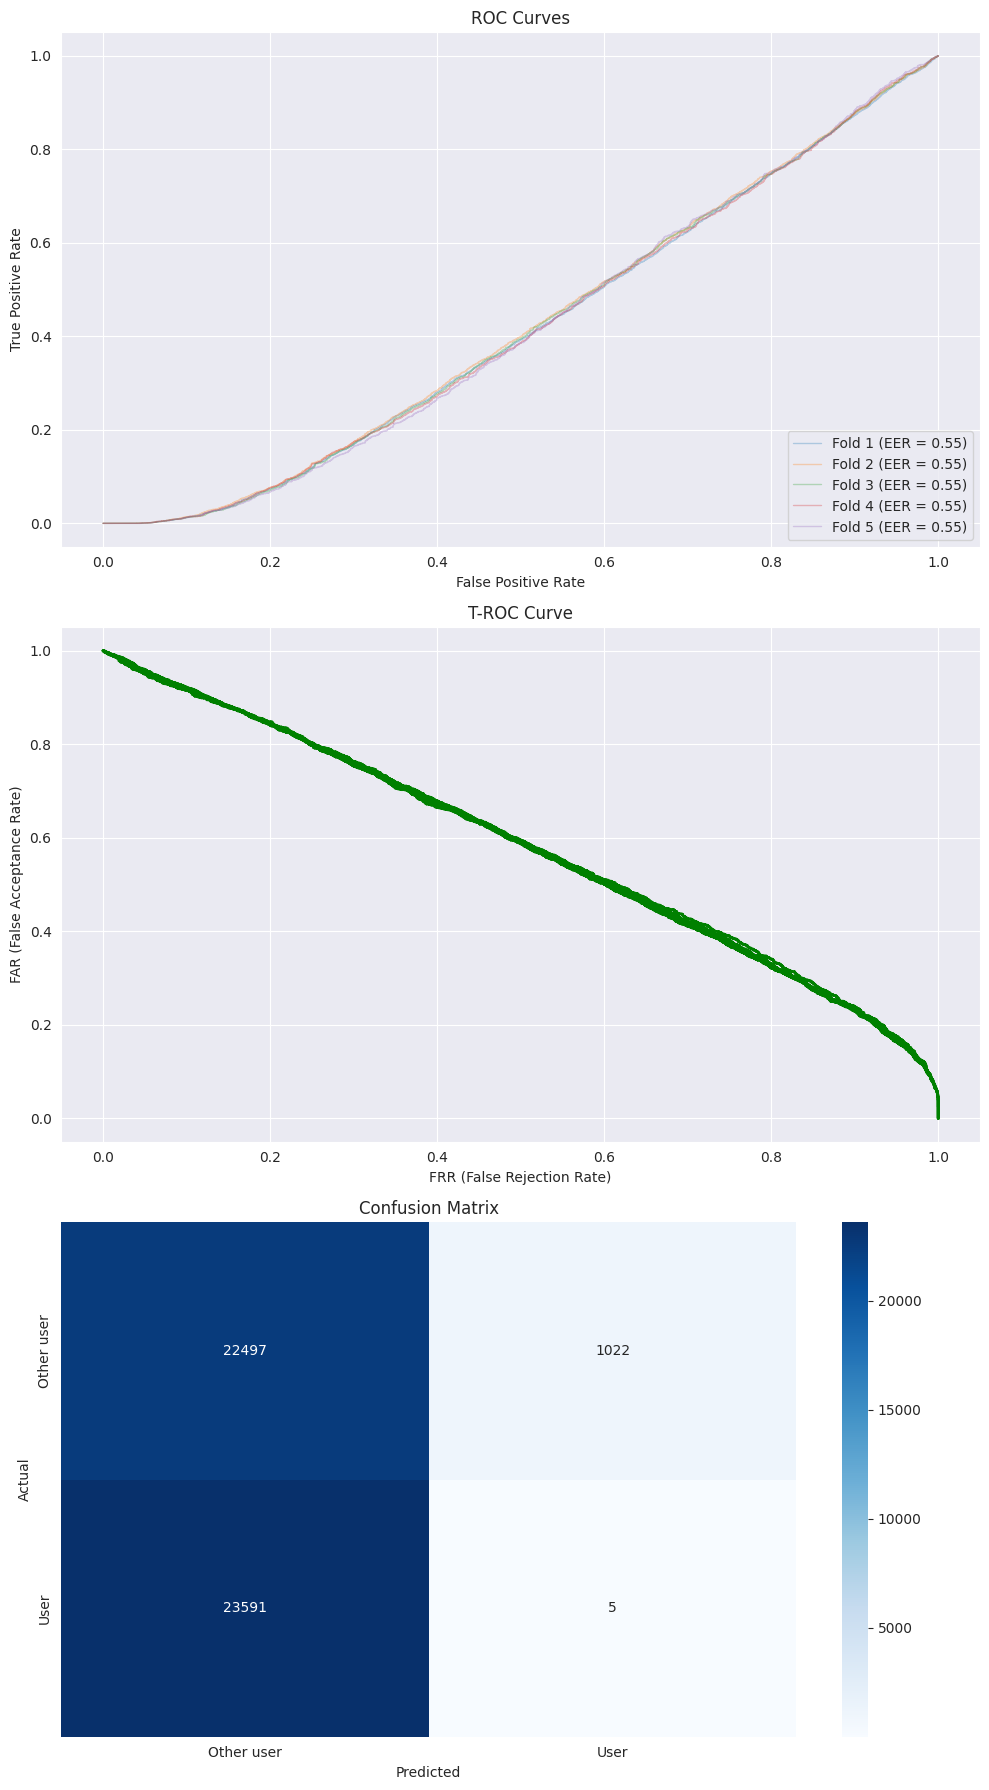

2023-09-05 01:18:24,377 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:18:24,386 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.010333. Found 696 examples.
2023-09-05 01:18:24,396 — absl — INFO — Training dataset read in 0:00:00.010333. Found 696 examples.
Training model...
2023-09-05 01:18:24,397 — absl — INFO — Training model...
Model trained in 0:00:00.153391
2023-09-05 01:18:24,550 — absl — INFO — Model trained in 0:00:00.153391
Compiling model...
2023-09-05 01:18:24,556 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:24.4525 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:24.4972 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:24.5465 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:24.5466 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:24,662 — absl — INFO — Model compiled.
21/21 - 0s - 93ms/epoch - 4ms/step
2023-09-05 01:18:24,815 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:18:24,821 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.007205. Found 696 examples.
2023-09-05 01:18:24,828 — absl — INFO — Training dataset read in 0:00:00.007205. Found 696 examples.
Training model...
2023-09-05 01:18:24,829 — absl — INFO — Training model...
Model trained in 0:00:00.146049
2023-09-05 01:18:24,975 — absl — INFO — Model trained in 0:00:00.146049
Compiling model...
2023-09-05 01:18:24,980 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:24.8851 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:24.9282 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:24.9716 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:24.9716 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:25,095 — absl — INFO — Model compiled.
16/16 - 0s - 76ms/epoch - 5ms/step
2023-09-05 01:18:25,223 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:18:25,229 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006912. Found 696 examples.
2023-09-05 01:18:25,236 — absl — INFO — Training dataset read in 0:00:00.006912. Found 696 examples.
Training model...
2023-09-05 01:18:25,237 — absl — INFO — Training model...
Model trained in 0:00:00.147553
2023-09-05 01:18:25,384 — absl — INFO — Model trained in 0:00:00.147553
Compiling model...
2023-09-05 01:18:25,385 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:25,490 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:25.2918 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:25.3322 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:25.3784 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:25.3784 CEST kernel.cc:1075] Use fast generic engine


12/12 - 0s - 93ms/epoch - 8ms/step
2023-09-05 01:18:25,665 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:18:25,671 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.011060. Found 696 examples.
2023-09-05 01:18:25,682 — absl — INFO — Training dataset read in 0:00:00.011060. Found 696 examples.
Training model...
2023-09-05 01:18:25,683 — absl — INFO — Training model...
Model trained in 0:00:00.184397
2023-09-05 01:18:25,868 — absl — INFO — Model trained in 0:00:00.184397
Compiling model...
2023-09-05 01:18:25,875 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:25.7563 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:25.8062 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:25.8630 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:25.8630 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:26,013 — absl — INFO — Model compiled.
9/9 - 0s - 63ms/epoch - 7ms/step
2023-09-05 01:18:26,129 — logger — INFO — X_train: (696, 10), y_train: (696,)
Reading training dataset...
2023-09-05 01:18:26,134 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.006581. Found 696 examples.
2023-09-05 01:18:26,141 — absl — INFO — Training dataset read in 0:00:00.006581. Found 696 examples.
Training model...
2023-09-05 01:18:26,142 — absl — INFO — Training model...
Model trained in 0:00:00.154894
2023-09-05 01:18:26,297 — absl — INFO — Model trained in 0:00:00.154894
Compiling model...
2023-09-05 01:18:26,301 — absl — INFO — Compiling model...
Model compiled.
2023-09-05 01:18:26,402 — absl — INFO — Model compiled.


[INFO 23-09-05 01:18:26.2093 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:26.2493 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:26.2925 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:26.2926 CEST kernel.cc:1075] Use fast generic engine


7/7 - 0s - 60ms/epoch - 9ms/step


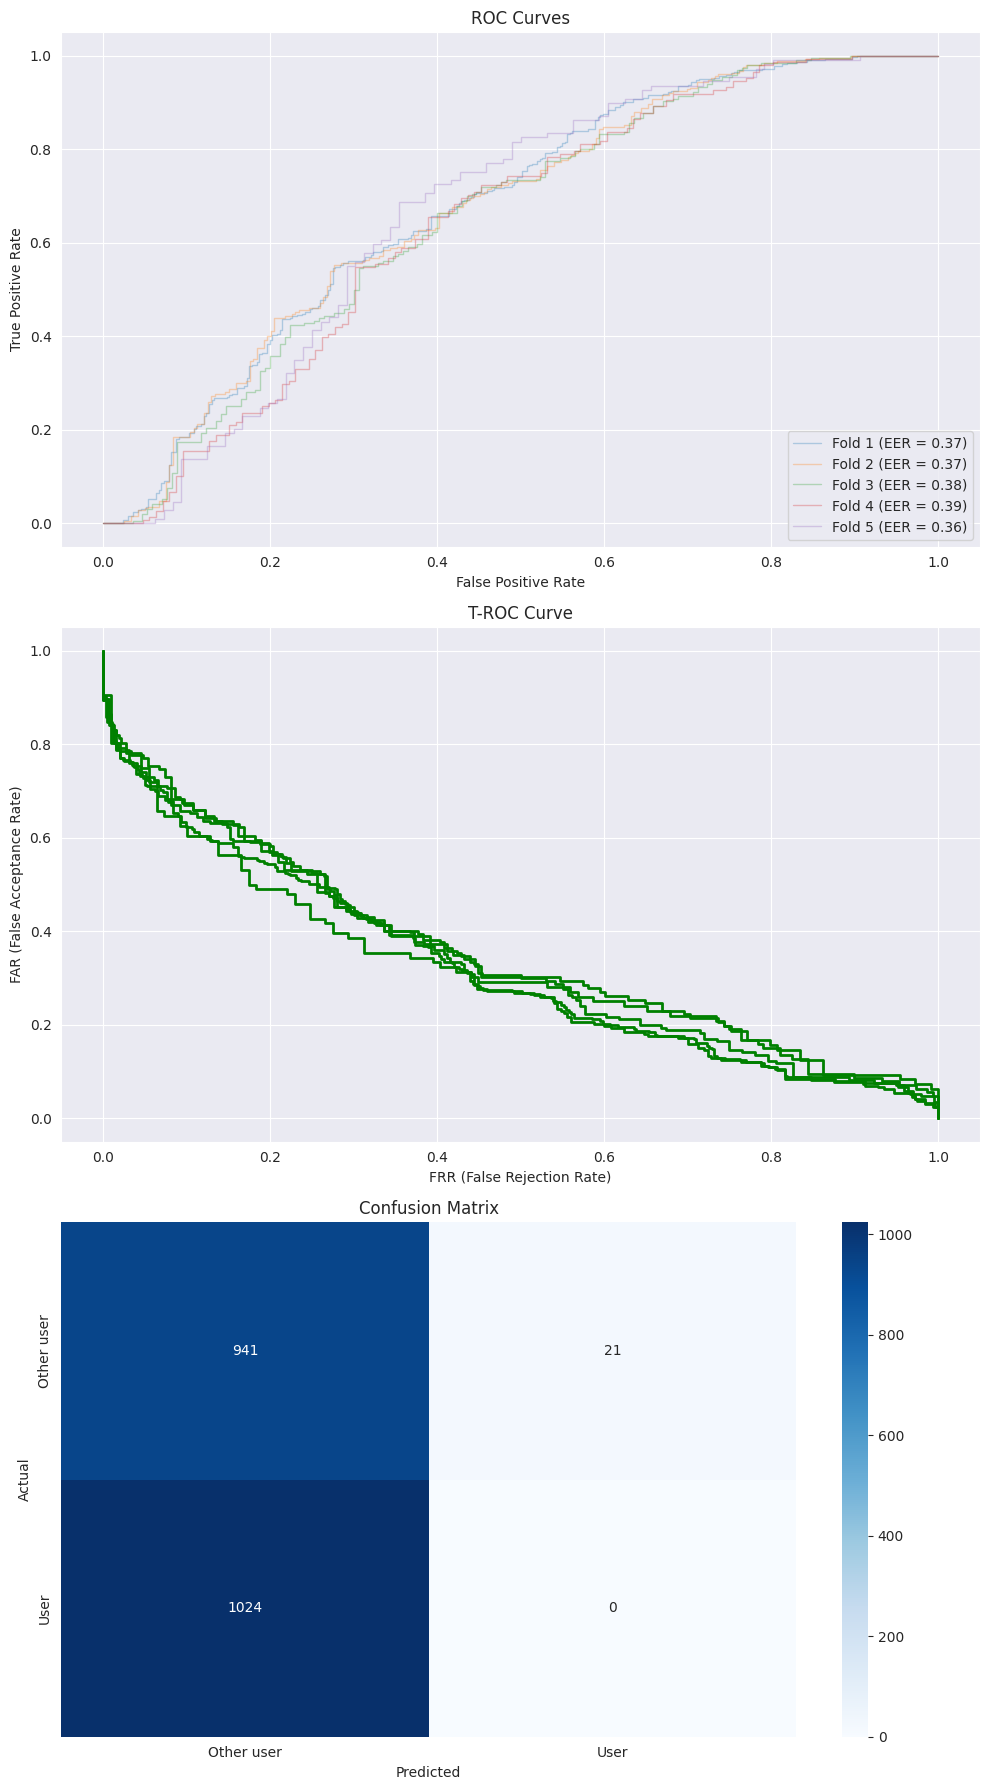

2023-09-05 01:18:28,346 — logger — INFO — X_train: (404, 10), y_train: (404,)
Reading training dataset...
2023-09-05 01:18:28,356 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.012486. Found 404 examples.
2023-09-05 01:18:28,368 — absl — INFO — Training dataset read in 0:00:00.012486. Found 404 examples.
Training model...
2023-09-05 01:18:28,370 — absl — INFO — Training model...
Model trained in 0:00:00.269707
2023-09-05 01:18:28,639 — absl — INFO — Model trained in 0:00:00.269707
Compiling model...
2023-09-05 01:18:28,646 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:28.4665 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:28.5382 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:28.6294 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:28.6301 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-05 01:18:28.6305 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:28,825 — absl — INFO — Model compiled.
25/25 - 0s - 194ms/epoch - 8ms/step
2023-09-05 01:18:29,109 — logger — INFO — X_train: (405, 10), y_train: (405,)
Reading training dataset...
2023-09-05 01:18:29,119 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.011355. Found 405 examples.
2023-09-05 01:18:29,131 — absl — INFO — Training dataset read in 0:00:00.011355. Found 405 examples.
Training model...
2023-09-05 01:18:29,132 — absl — INFO — Training model...
Model trained in 0:00:00.203580
2023-09-05 01:18:29,336 — absl — INFO — Model trained in 0:00:00.203580
Compiling model...
2023-09-05 01:18:29,342 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:29.2319 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:29.2740 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:29.3310 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:29.3310 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:29,486 — absl — INFO — Model compiled.
19/19 - 0s - 114ms/epoch - 6ms/step
2023-09-05 01:18:29,691 — logger — INFO — X_train: (405, 10), y_train: (405,)
Reading training dataset...
2023-09-05 01:18:29,699 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.009073. Found 405 examples.
2023-09-05 01:18:29,708 — absl — INFO — Training dataset read in 0:00:00.009073. Found 405 examples.
Training model...
2023-09-05 01:18:29,710 — absl — INFO — Training model...
Model trained in 0:00:00.205258
2023-09-05 01:18:29,915 — absl — INFO — Model trained in 0:00:00.205258
Compiling model...
2023-09-05 01:18:29,921 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:29.7827 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:29.8263 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:29.9106 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:29.9106 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:30,087 — absl — INFO — Model compiled.
14/14 - 0s - 113ms/epoch - 8ms/step
2023-09-05 01:18:30,278 — logger — INFO — X_train: (405, 10), y_train: (405,)
Reading training dataset...
2023-09-05 01:18:30,290 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.009912. Found 405 examples.
2023-09-05 01:18:30,300 — absl — INFO — Training dataset read in 0:00:00.009912. Found 405 examples.
Training model...
2023-09-05 01:18:30,301 — absl — INFO — Training model...
Model trained in 0:00:00.168117
2023-09-05 01:18:30,469 — absl — INFO — Model trained in 0:00:00.168117
Compiling model...
2023-09-05 01:18:30,476 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:30.3669 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:30.4106 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:30.4651 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:30.4651 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:30,651 — absl — INFO — Model compiled.
11/11 - 0s - 71ms/epoch - 6ms/step
2023-09-05 01:18:30,795 — logger — INFO — X_train: (405, 10), y_train: (405,)
Reading training dataset...
2023-09-05 01:18:30,800 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.008434. Found 405 examples.
2023-09-05 01:18:30,809 — absl — INFO — Training dataset read in 0:00:00.008434. Found 405 examples.
Training model...
2023-09-05 01:18:30,810 — absl — INFO — Training model...
Model trained in 0:00:00.185093
2023-09-05 01:18:30,995 — absl — INFO — Model trained in 0:00:00.185093
Compiling model...
2023-09-05 01:18:31,005 — absl — INFO — Compiling model...


[INFO 23-09-05 01:18:30.8682 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:30.9057 CEST kernel.cc:1243] Loading model from path /tmp/tmp0lir8oj4/model/ with prefix 96cbf1715be24ec4
[INFO 23-09-05 01:18:30.9862 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18192 node(s), and 10 input feature(s).
[INFO 23-09-05 01:18:30.9862 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-05 01:18:31,149 — absl — INFO — Model compiled.
8/8 - 0s - 68ms/epoch - 8ms/step


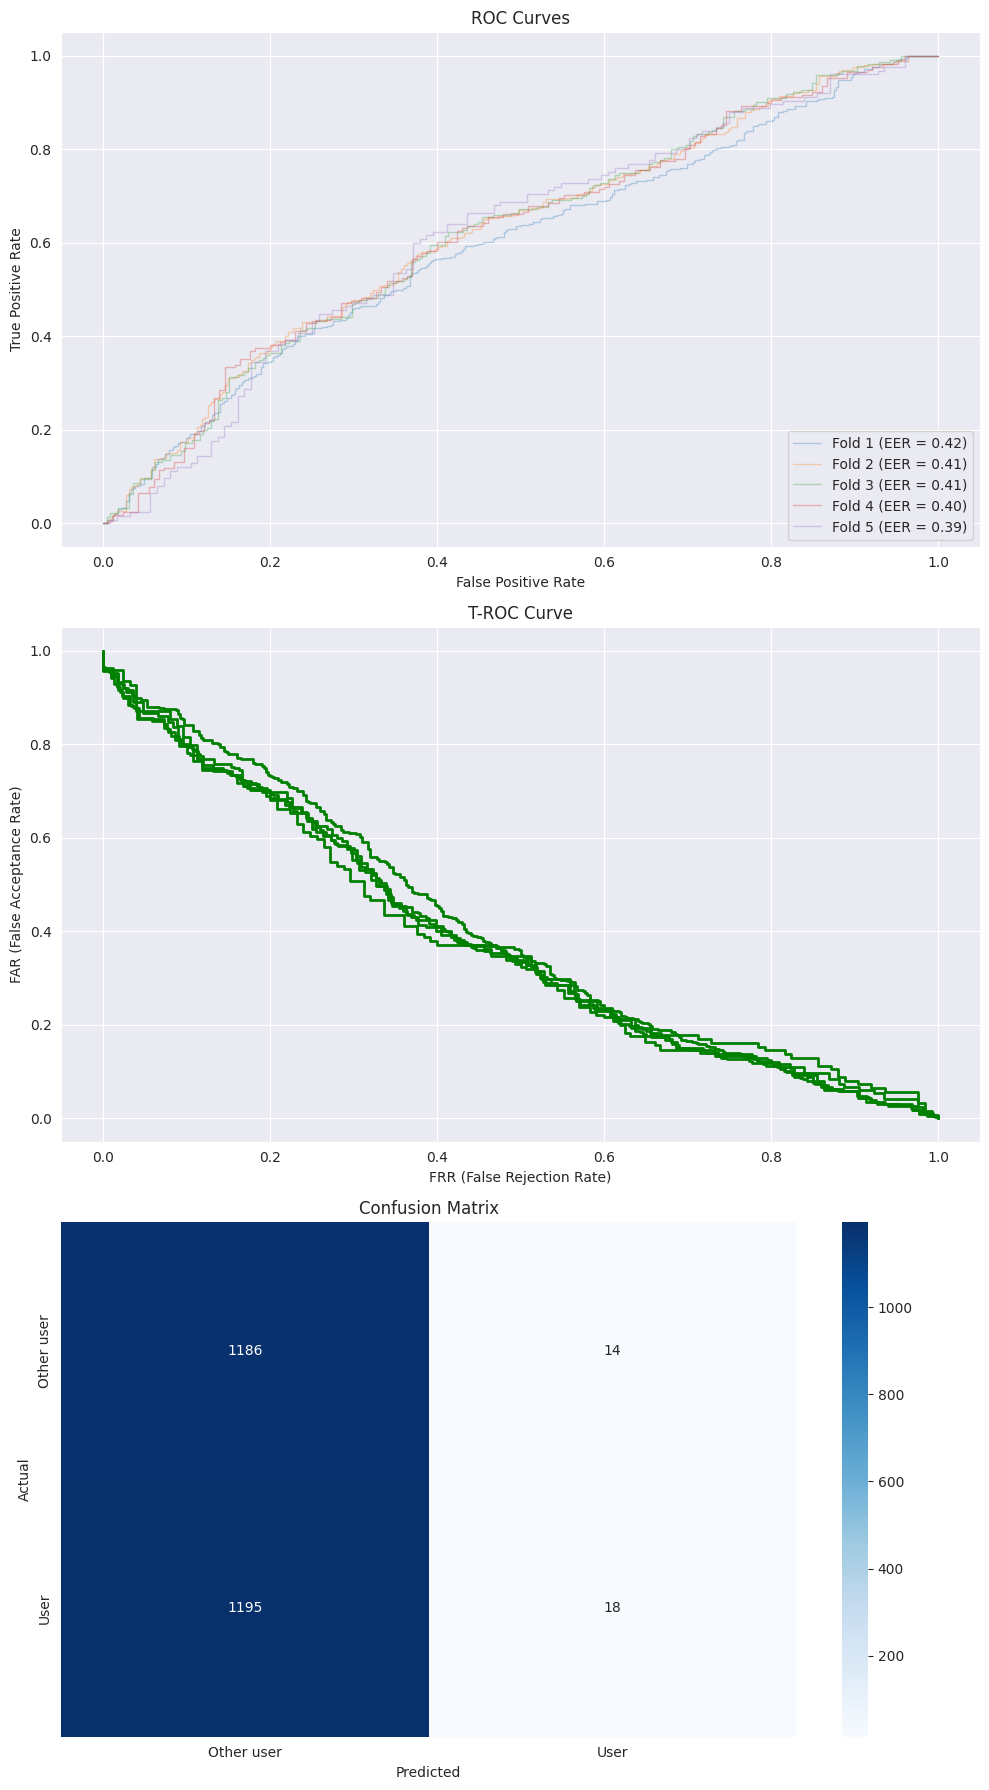

In [48]:
final_df_list = []
for user in np.unique(y):
    final_df_list.append(train_and_evaluate_for_user(model, None, X, y, X_test, y_test, user))